In [8]:
import os, cv2, json, uuid, time, pickle, requests, torch
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"
WORKFLOW_JSON = "ClothesArmsFaceNeck.json"
ENLARGE_PERCENT = 0.2
# =================

output1 = "clothes"
output2 = "arms"
output3 = "neck"
output4 = "faces"

# output1 = "face"
# output2 = "bike"
# output3 = "car"
# output4 = "scooty"

#######################

# Prompts + thresholds (can be edited dynamically or even loaded from a file/CLI args)
SEGMENT_CONFIG = {
    "2": {"prompt": output1, "threshold": 0.30},
    "6": {"prompt": output2,    "threshold": 0.30},
    "8": {"prompt": output3,   "threshold": 0.30},
    "10": {"prompt": output4,  "threshold": 0.30}
}





# ---- Setup models ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)
device_str = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- DeOldify ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- ComfyUI Helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_ROOT, "comfy_downloads")
    os.makedirs(save_dir, exist_ok=True)
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    if to_path is None:
        to_path = os.path.join(save_dir, filename)
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path

def run_multi_masks(frame_path, comfy_server=COMFY):
    uploaded = upload_image_to_comfy(frame_path, server=comfy_server)
    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)

    # patch LoadImage
    for node in prompt.values():
        if node.get("class_type", "").lower() == "loadimage":
            node["inputs"]["image"] = uploaded

    # Patch prompts + thresholds dynamically
    for node_id, cfg in SEGMENT_CONFIG.items():
        if node_id in prompt:
            prompt[node_id]["inputs"]["prompt"] = cfg["prompt"]
            prompt[node_id]["inputs"]["threshold"] = cfg["threshold"]

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 600
    masks = {}

    # mapping node_id -> semantic name
    id_to_name = {
        "12": output1,
        "13": output2,
        "14": output3,
        "15": output4
    }

    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_id, node_out in item["outputs"].items():
                for im in node_out.get("images", []):
                    fn = im["filename"]
                    sub = im.get("subfolder", "")
                    typ = im.get("type", "output")
                    out_path = os.path.join(os.path.dirname(frame_path),
                                            f"{id_to_name.get(node_id, node_id)}_{os.path.basename(frame_path)}")
                    dl_path = download_image(fn, server=comfy_server,
                                             subfolder=sub, folder_type=typ, to_path=out_path)
                    masks[id_to_name.get(node_id, node_id)] = dl_path
        if masks:
            break
        time.sleep(0.5)

    return masks


# ---- Utility ----
def ensure_binary(img, size):
    if img is None:
        return np.zeros(size, dtype=np.uint8)
    img = cv2.resize(img, size)
    _, bin_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    return bin_img


# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")
    if os.path.exists(yolo_path):
        with open(yolo_path, "rb") as f:
            return pickle.load(f)

    results_per_frame = []
    cap = cv2.VideoCapture(input_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret: break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            results_per_frame.append({
                "boxes": results[0].boxes.xyxy.cpu().numpy(),
                "conf": results[0].boxes.conf.cpu().numpy(),
                "cls": results[0].boxes.cls.cpu().numpy()
            })
            pbar.update(1)
    cap.release()

    with open(yolo_path, "wb") as f:
        pickle.dump(results_per_frame, f)
    return results_per_frame


def run_yolo(input_path, out_dir, name):
    """
    Run YOLO on a video, save both detection results (.pkl)
    and an annotated output video (.mp4).
    """
    # ---- Output paths ----
    yolo_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")
    yolo_video_path = os.path.join(out_dir, f"{name}_yolo_output.mp4")

    # ---- Use cache if available ----
    if os.path.exists(yolo_path) and os.path.exists(yolo_video_path):
        with open(yolo_path, "rb") as f:
            return pickle.load(f)

    # ---- Setup video I/O ----
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    os.makedirs(out_dir, exist_ok=True)
    writer = cv2.VideoWriter(yolo_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    # ---- Detection loop ----
    results_per_frame = []
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run YOLO inference
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confs = results[0].boxes.conf.cpu().numpy()
            classes = results[0].boxes.cls.cpu().numpy()

            # Store frame-level results
            results_per_frame.append({
                "boxes": boxes,
                "conf": confs,
                "cls": classes
            })

            # Draw detections on frame
            annotated_frame = results[0].plot()  # YOLO's built-in plot()
            writer.write(annotated_frame)

            pbar.update(1)

    # ---- Cleanup ----
    cap.release()
    writer.release()

    # ---- Save detection results ----
    with open(yolo_path, "wb") as f:
        pickle.dump(results_per_frame, f)

    print(f"[YOLO] Saved annotated video → {yolo_video_path}")
    print(f"[YOLO] Saved detection results → {yolo_path}")
    return results_per_frame



# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(deoldify_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, f_bgr = cap.read()
            if not ret: break
            f_rgb = cv2.cvtColor(f_bgr, cv2.COLOR_BGR2RGB)
            deold = deoldify_inference(f_rgb)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()
    writer.release()
    return deoldify_path


def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(deoldify_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, f_bgr = cap.read()
            if not ret: break

            # 🔹 Force grayscale input
            f_gray = cv2.cvtColor(f_bgr, cv2.COLOR_BGR2GRAY)
            f_gray3 = cv2.cvtColor(f_gray, cv2.COLOR_GRAY2RGB)

            deold = deoldify_inference(f_gray3)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)

    cap.release()
    writer.release()
    return deoldify_path


import os
import subprocess

def run_deoldify(input_path, out_dir, name, first_path=None):
    """
    Run U-Net video colorization via subprocess (cached).
    
    Parameters:
        input_path (str): Path to grayscale input video
        out_dir (str): Directory to save output video
        name (str): Base name for output video
        first_path (str, optional): Placeholder for compatibility with old API
    
    Returns:
        str: Path to the colorized video
    """
    unet_video_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(unet_video_path):
        return unet_video_path

    # 🔹 Hardcoded generator weights path
    generator_weights = "models/best_weights_epoch_0004.weights.h5"

    # 🔹 Call the existing cached subprocess wrapper
    from Utils.main_utils import run_unet_colorization_cached_subprocess
    unet_video_path = run_unet_colorization_cached_subprocess(
        input_bw_video=input_path,
        unet_weights=generator_weights,
        first_path=first_path or input_path
    )

    return unet_video_path




# ---- Stage 3: Precompute SAM masks (MaskA + MaskB videos) ----
def run_sam_masks_(input_path, out_dir, name):
    maskA_path = os.path.join(out_dir, f"{name}_maskA.mp4")
    maskB_path = os.path.join(out_dir, f"{name}_maskB.mp4")
    if os.path.exists(maskA_path) and os.path.exists(maskB_path):
        return maskA_path, maskB_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writerA = cv2.VideoWriter(maskA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(maskB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        idx = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            frame_file = os.path.join(out_dir, f"frame_{idx:06d}.png")
            cv2.imwrite(frame_file, frame)

            masks = run_multi_masks(frame_file, comfy_server=COMFY)
            mask_imgs = {}
            for k, v in masks.items():
                img = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    mask_imgs[k] = ensure_binary(img, (width, height))

            mask_out1 = mask_imgs.get(output1, np.zeros((height, width), np.uint8))
            mask_out2 = mask_imgs.get(output2, np.zeros((height, width), np.uint8))
            mask_out3 = mask_imgs.get(output3, np.zeros((height, width), np.uint8))
            mask_out4 = mask_imgs.get(output4, np.zeros((height, width), np.uint8))
            
            others = cv2.bitwise_or(mask_out2, cv2.bitwise_or(mask_out3, mask_out4))
            maskA = cv2.bitwise_and(mask_out1, cv2.bitwise_not(others))  # exclusive output1
            others_B = cv2.bitwise_or(mask_out1, mask_out4)
            #maskB = cv2.bitwise_or(mask_out2, mask_out3)                # output2 + output3
            maskB = cv2.bitwise_and(cv2.bitwise_or(mask_out2, mask_out3), cv2.bitwise_not(others_B))

            writerA.write(cv2.cvtColor(maskA, cv2.COLOR_GRAY2BGR))
            writerB.write(cv2.cvtColor(maskB, cv2.COLOR_GRAY2BGR))

            idx += 1
            pbar.update(1)

    cap.release()
    writerA.release()
    writerB.release()
    return maskA_path, maskB_path






def run_sam_masks(input_path, out_dir, name, yolo_results=None):
    """
    Generate SAM masks (MaskA + MaskB videos), but only keep SAM outputs
    that overlap with YOLO bounding boxes. Includes debug prints for each stage.
    """
    maskA_path = os.path.join(out_dir, f"{name}_maskA.mp4")
    maskB_path = os.path.join(out_dir, f"{name}_maskB.mp4")

    if os.path.exists(maskA_path) and os.path.exists(maskB_path):
        print(f"[CACHE] Using existing SAM mask videos for {name}")
        return maskA_path, maskB_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    os.makedirs(out_dir, exist_ok=True)
    writerA = cv2.VideoWriter(maskA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(maskB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    print(f"[INFO] Starting SAM mask generation on {total_frames} frames ({width}x{height})...")

    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            maskA = np.zeros((height, width), np.uint8)
            maskB = np.zeros((height, width), np.uint8)

            # --- Step 1: YOLO detection check ---
            if yolo_results and idx < len(yolo_results):
                boxes = yolo_results[idx]["boxes"]
                confs = yolo_results[idx]["conf"]
                boxes = [b for b, c in zip(boxes, confs) if c >= CONF_THRESHOLD]

                print(f"\n[DEBUG] Frame {idx}: YOLO boxes = {len(boxes)}")
                if len(boxes) > 0:
                    for i, b in enumerate(boxes):
                        print(f"    Box {i}: {b}")

                    # --- Step 2: Run SAM ---
                    frame_file = os.path.join(out_dir, f"frame_{idx:06d}.png")
                    cv2.imwrite(frame_file, frame)
                    masks = run_multi_masks(frame_file, comfy_server=COMFY)
                    print(f"[DEBUG] Frame {idx}: SAM returned {list(masks.keys())}")

                    # --- Step 3: Read SAM mask files ---
                    mask_imgs = {}
                    for k, v in masks.items():
                        img = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            mask_imgs[k] = ensure_binary(img, (width, height))
                            print(f"[DEBUG]   Mask '{k}' nonzero pixels: {np.count_nonzero(img)}")
                        else:
                            print(f"[WARN]    Mask '{k}' could not be read from {v}")

                    # --- Step 4: Combine SAM masks ---
                    mask_out1 = mask_imgs.get(output1, np.zeros((height, width), np.uint8))
                    mask_out2 = mask_imgs.get(output2, np.zeros((height, width), np.uint8))
                    mask_out3 = mask_imgs.get(output3, np.zeros((height, width), np.uint8))
                    mask_out4 = mask_imgs.get(output4, np.zeros((height, width), np.uint8))

                    others = cv2.bitwise_or(mask_out2, cv2.bitwise_or(mask_out3, mask_out4))
                    tempA = cv2.bitwise_and(mask_out1, cv2.bitwise_not(others))
                    others_B = cv2.bitwise_or(mask_out1, mask_out4)
                    tempB = cv2.bitwise_and(cv2.bitwise_or(mask_out2, mask_out3),
                                            cv2.bitwise_not(others_B))
                    print(f"[DEBUG] Frame {idx}: tempA nonzero = {np.count_nonzero(tempA)}, tempB nonzero = {np.count_nonzero(tempB)}")

                    # --- Step 5: Build YOLO mask ---
                    yolo_mask = np.zeros((height, width), dtype=np.uint8)
                    for box in boxes:
                        x1, y1, x2, y2 = map(int, box)
                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(width, x2), min(height, y2)
                        yolo_mask[y1:y2, x1:x2] = 255

                    print(f"[DEBUG] Frame {idx}: YOLO mask nonzero = {np.count_nonzero(yolo_mask)}")

                    # --- Step 6: Intersect YOLO with SAM ---
                    maskA = cv2.bitwise_and(tempA, yolo_mask)
                    maskB = cv2.bitwise_and(tempB, yolo_mask)

                    print(f"[DEBUG] Frame {idx}: After intersection maskA={np.count_nonzero(maskA)}, maskB={np.count_nonzero(maskB)}")

                    # --- Step 7: Handle empty masks ---
                    if np.count_nonzero(maskA) == 0 and np.count_nonzero(maskB) == 0:
                        print(f"[INFO] Frame {idx}: SAM masks outside YOLO boxes → discarded")
                        maskA = np.zeros((height, width), np.uint8)
                        maskB = np.zeros((height, width), np.uint8)

            else:
                print(f"[DEBUG] Frame {idx}: No YOLO detections, skipping SAM")

            # --- Step 8: Write results (masked or blank) ---
            writerA.write(cv2.cvtColor(maskA, cv2.COLOR_GRAY2BGR))
            writerB.write(cv2.cvtColor(maskB, cv2.COLOR_GRAY2BGR))

            idx += 1
            pbar.update(1)

    cap.release()
    writerA.release()
    writerB.release()
    print(f"[INFO] SAM mask generation complete → {maskA_path}, {maskB_path}")
    return maskA_path, maskB_path



def run_sam_masks(input_path, out_dir, name, yolo_results):
    maskA_path = os.path.join(out_dir, f"{name}_maskA.mp4")
    maskB_path = os.path.join(out_dir, f"{name}_maskB.mp4")
    if os.path.exists(maskA_path) and os.path.exists(maskB_path):
        return maskA_path, maskB_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    writerA = cv2.VideoWriter(maskA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(maskB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Skip if YOLO found nothing
            if idx >= len(yolo_results) or len(yolo_results[idx]["boxes"]) == 0:
                writerA.write(np.zeros((height, width, 3), dtype=np.uint8))
                writerB.write(np.zeros((height, width, 3), dtype=np.uint8))
                idx += 1
                pbar.update(1)
                continue

            frame_file = os.path.join(out_dir, f"frame_{idx:06d}.png")
            cv2.imwrite(frame_file, frame)
            masks = run_multi_masks(frame_file, comfy_server=COMFY)

            mask_imgs = {}
            for k, v in masks.items():
                img = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    mask_imgs[k] = ensure_binary(img, (width, height))

            mask_out1 = mask_imgs.get(output1, np.zeros((height, width), np.uint8))
            mask_out2 = mask_imgs.get(output2, np.zeros((height, width), np.uint8))
            mask_out3 = mask_imgs.get(output3, np.zeros((height, width), np.uint8))
            mask_out4 = mask_imgs.get(output4, np.zeros((height, width), np.uint8))

            others = cv2.bitwise_or(mask_out2, cv2.bitwise_or(mask_out3, mask_out4))
            maskA = cv2.bitwise_and(mask_out1, cv2.bitwise_not(others))
            others_B = cv2.bitwise_or(mask_out1, mask_out4)
            maskB = cv2.bitwise_and(cv2.bitwise_or(mask_out2, mask_out3), cv2.bitwise_not(others_B))

            # Apply YOLO bounding box restriction
            yolo_mask = np.zeros((height, width), np.uint8)
            for box in yolo_results[idx]["boxes"]:
                x1, y1, x2, y2 = map(int, box)
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(width, x2), min(height, y2)
                yolo_mask[y1:y2, x1:x2] = 255

            maskA = cv2.bitwise_and(maskA, yolo_mask)
            maskB = cv2.bitwise_and(maskB, yolo_mask)

            # If both masks are empty → discard
            if np.count_nonzero(maskA) == 0 and np.count_nonzero(maskB) == 0:
                writerA.write(np.zeros((height, width, 3), dtype=np.uint8))
                writerB.write(np.zeros((height, width, 3), dtype=np.uint8))
            else:
                writerA.write(cv2.cvtColor(maskA, cv2.COLOR_GRAY2BGR))
                writerB.write(cv2.cvtColor(maskB, cv2.COLOR_GRAY2BGR))

            idx += 1
            pbar.update(1)

    cap.release()
    writerA.release()
    writerB.release()
    return maskA_path, maskB_path



# ---- Stage 4: Fusion ----
def run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, maskA_path, maskB_path):
    finalA_path = os.path.join(out_dir, f"{name}_finalA.mp4")
    finalB_path = os.path.join(out_dir, f"{name}_finalB.mp4")
    if os.path.exists(finalA_path) and os.path.exists(finalB_path):
        return finalA_path, finalB_path

    cap_in = cv2.VideoCapture(input_path)
    cap_de = cv2.VideoCapture(deoldify_path)
    cap_A  = cv2.VideoCapture(maskA_path)
    cap_B  = cv2.VideoCapture(maskB_path)

    fps = int(cap_in.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_in.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writerA = cv2.VideoWriter(finalA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(finalB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    frame_idx = 0
    with tqdm(total=len(yolo_results), desc="Fusion", unit="frame") as pbar:
        while frame_idx < len(yolo_results):
            ret_in, f_in = cap_in.read()
            ret_de, f_de = cap_de.read()
            ret_A, f_A = cap_A.read()
            ret_B, f_B = cap_B.read()
            if not (ret_in and ret_de and ret_A and ret_B): break

            grayA = cv2.cvtColor(f_A, cv2.COLOR_BGR2GRAY)
            grayB = cv2.cvtColor(f_B, cv2.COLOR_BGR2GRAY)

            _, maskA = cv2.threshold(grayA, 1, 255, cv2.THRESH_BINARY)
            _, maskB = cv2.threshold(grayB, 1, 255, cv2.THRESH_BINARY)

            # YOLO restriction
            yolo_mask = np.zeros((height, width), dtype=np.uint8)
            for box, conf, cls in zip(yolo_results[frame_idx]["boxes"],
                                      yolo_results[frame_idx]["conf"],
                                      yolo_results[frame_idx]["cls"]):
                if int(cls) != 0 or conf < CONF_THRESHOLD: continue
                x1, y1, x2, y2 = map(int, box)
                dx = int((x2 - x1) * ENLARGE_PERCENT)
                dy = int((y2 - y1) * ENLARGE_PERCENT)
                x1 = max(0, x1 - dx); y1 = max(0, y1 - dy)
                x2 = min(width, x2 + dx); y2 = min(height, y2 + dy)
                yolo_mask[y1:y2, x1:x2] = 255

            maskA = cv2.bitwise_and(maskA, yolo_mask)
            maskB = cv2.bitwise_and(maskB, yolo_mask)

            fA = f_in.copy(); fA[maskA > 127] = f_de[maskA > 127]
            fB = f_in.copy(); fB[maskB > 127] = f_de[maskB > 127]

            writerA.write(fA)
            writerB.write(fB)

            frame_idx += 1
            pbar.update(1)

    cap_in.release(); cap_de.release(); cap_A.release(); cap_B.release()
    writerA.release(); writerB.release()
    return finalA_path, finalB_path


# ---- Main Pipeline ----
def process_video_with_multi_masks(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    maskA_path, maskB_path = run_sam_masks(input_path, out_dir, name,yolo_results)
    finalA_path, finalB_path = run_fusion(input_path, out_dir, name, yolo_results,
                                          deoldify_path, maskA_path, maskB_path)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "deoldify": deoldify_path,
        "maskA": maskA_path,
        "maskB": maskB_path,
        "finalA": finalA_path,
        "finalB": finalB_path
    }


# ---- Example ----
if __name__ == "__main__":
    input_video = "input_videos/colored_full_video_maskedmerge.mp4"
    outputs = process_video_with_multi_masks(input_video)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


CUDA available: True
CUDA device count: 1
Using: NVIDIA GeForce RTX 4060 Ti
[CACHE] Colorized output already exists: output_videos_latest/colored_full_video_maskedmerge/unet_colored_refs__67d1a4bb14e9/unet_colored_refs.mp4
[INFO] Outputs written to outputs/colored_full_video_maskedmerge
Pipeline outputs:
 - deoldify: output_videos_latest/colored_full_video_maskedmerge/unet_colored_refs__67d1a4bb14e9/unet_colored_refs.mp4
 - maskA: outputs/colored_full_video_maskedmerge/colored_full_video_maskedmerge_maskA.mp4
 - maskB: outputs/colored_full_video_maskedmerge/colored_full_video_maskedmerge_maskB.mp4
 - finalA: outputs/colored_full_video_maskedmerge/colored_full_video_maskedmerge_finalA.mp4
 - finalB: outputs/colored_full_video_maskedmerge/colored_full_video_maskedmerge_finalB.mp4


In [6]:
import pickle
path = "outputs/colored_full_video_maskedmerge/colored_full_video_maskedmerge_yolo_results.pkl"
with open(path, "rb") as f:
    yolo_results = pickle.load(f)

detected = sum(1 for r in yolo_results if len(r["boxes"]) > 0)
print(f"YOLO detected {detected}/{len(yolo_results)} frames")


YOLO detected 23/29 frames


In [3]:
def process_image_with_multi_masks(input_image):
    folder, fname = os.path.split(input_image)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    # ---- Load input ----
    frame_bgr = cv2.imread(input_image)
    if frame_bgr is None:
        raise FileNotFoundError(f"Could not load image {input_image}")
    h, w = frame_bgr.shape[:2]
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    # ---- Stage 1: YOLO ----
    results = yolo_model.predict(frame_bgr, conf=CONF_THRESHOLD, verbose=False, device=device_str)
    yolo_boxes = results[0].boxes.xyxy.cpu().numpy()
    yolo_conf  = results[0].boxes.conf.cpu().numpy()
    yolo_cls   = results[0].boxes.cls.cpu().numpy()

    # ---- Stage 2: DeOldify ----

    f_gray = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)
    f_gray3 = cv2.cvtColor(f_gray, cv2.COLOR_GRAY2RGB)
    deold = deoldify_inference(f_gray3)
    deold_bgr = cv2.cvtColor(deold, cv2.COLOR_RGB2BGR)
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.png")
    cv2.imwrite(deoldify_path, deold_bgr)

    # ---- Stage 3: SAM (multi-mask) ----
    try:
        masks = run_multi_masks(input_image, comfy_server=COMFY)  # dict {"clothes": path, "arms": path, ...}
        mask_imgs = {}
        for k, v in masks.items():
            img = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                mask_imgs[k] = ensure_binary(img, (w, h))
    except Exception as e:
        print(f"⚠️ SAM failed on image: {e}")
        mask_imgs = {}

    mask_out1 = mask_imgs.get(output1, np.zeros((h, w), np.uint8))
    mask_out2 = mask_imgs.get(output2, np.zeros((h, w), np.uint8))
    mask_out3 = mask_imgs.get(output3, np.zeros((h, w), np.uint8))
    mask_out4 = mask_imgs.get(output4, np.zeros((h, w), np.uint8))
    
    others = cv2.bitwise_or(mask_out2, cv2.bitwise_or(mask_out3, mask_out4))
    maskA = cv2.bitwise_and(mask_out1, cv2.bitwise_not(others))  # exclusive output1
    maskB = cv2.bitwise_or(mask_out2, mask_out3)                # output2 + output3


    # ---- Stage 5: Restrict to YOLO boxes ----
    yolo_mask = np.zeros((h, w), dtype=np.uint8)
    for box, conf, cls in zip(yolo_boxes, yolo_conf, yolo_cls):
        if int(cls) != 0 or conf < CONF_THRESHOLD:  # only person
            continue
        x1, y1, x2, y2 = map(int, box)
        dx = int((x2 - x1) * ENLARGE_PERCENT)
        dy = int((y2 - y1) * ENLARGE_PERCENT)
        x1 = max(0, x1 - dx); y1 = max(0, y1 - dy)
        x2 = min(w, x2 + dx); y2 = min(h, y2 + dy)
        yolo_mask[y1:y2, x1:x2] = 255

    maskA = cv2.bitwise_and(maskA, yolo_mask)
    maskB = cv2.bitwise_and(maskB, yolo_mask)

    # ---- Stage 6: Fusion ----
    fusionA = frame_bgr.copy()
    fusionA[maskA > 127] = deold_bgr[maskA > 127]

    fusionB = frame_bgr.copy()
    fusionB[maskB > 127] = deold_bgr[maskB > 127]

    # ---- Save outputs ----
    maskA_path = os.path.join(out_dir, f"{name}_maskA_exclusive_{output1}.png")
    maskB_path = os.path.join(out_dir, f"{name}_maskB_{output2}_{output3}.png")
    fusionA_path = os.path.join(out_dir, f"{name}_finalA_exclusive_{output1}.png")
    fusionB_path = os.path.join(out_dir, f"{name}_finalB_{output2}_{output3}.png")


    cv2.imwrite(maskA_path, maskA)
    cv2.imwrite(maskB_path, maskB)
    cv2.imwrite(fusionA_path, fusionA)
    cv2.imwrite(fusionB_path, fusionB)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "deoldify": deoldify_path,
        "maskA": maskA_path,
        "maskB": maskB_path,
        "finalA": fusionA_path,
        "finalB": fusionB_path
    }


# ---- Example ----
if __name__ == "__main__":
    input_image = "input_videos/first_frame.jpg"
    outputs = process_image_with_multi_masks(input_image)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


[INFO] Outputs written to outputs/first_frame
Pipeline outputs:
 - deoldify: outputs/first_frame/first_frame_deoldify.png
 - maskA: outputs/first_frame/first_frame_maskA_exclusive_clothes.png
 - maskB: outputs/first_frame/first_frame_maskB_arms_neck.png
 - finalA: outputs/first_frame/first_frame_finalA_exclusive_clothes.png
 - finalB: outputs/first_frame/first_frame_finalB_arms_neck.png


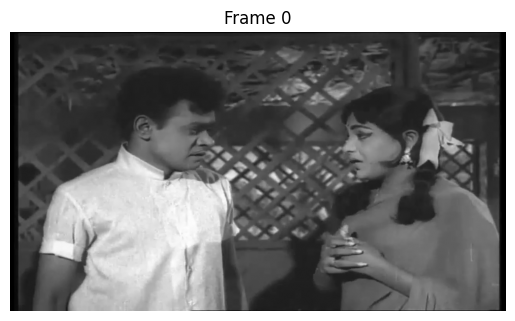

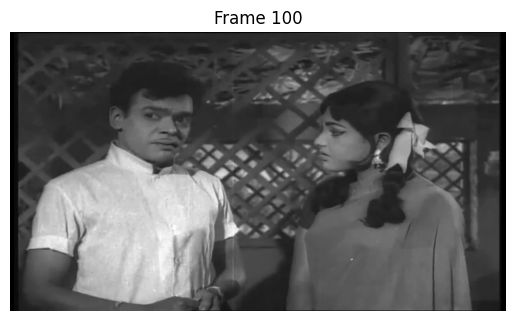

✅ Processing complete. Saved output video to: input_videos/thatha_manavadu_test_bw.mp4


In [4]:
import cv2
from matplotlib import pyplot as plt

# Input and output file paths
input_path = "input_videos/thatha_manavadu_test.mp4"
output_path = "input_videos/thatha_manavadu_test_bw.mp4"

# Open the input video
cap = cv2.VideoCapture(input_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30  # fallback if FPS=0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define codec and create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Convert back to 3-channel (needed for mp4 output)
    gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Write frame to output video
    out.write(gray_3ch)

    # Show preview every 100 frames inside notebook
    if frame_count % 100 == 0:
        plt.imshow(gray, cmap="gray")
        plt.axis("off")
        plt.title(f"Frame {frame_count}")
        plt.show()

    frame_count += 1

cap.release()
out.release()

print(f"✅ Processing complete. Saved output video to: {output_path}")


In [14]:
import os, cv2, json, uuid, time, pickle, requests, torch, subprocess
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"
WORKFLOW_JSON = "ClothesArmsFaceNeck.json"
ENLARGE_PERCENT = 0.2
TOP_K_BBOX = 6   # 🔹 new parameter to limit number of boxes per frame
# =================

output1 = "clothes"
output2 = "arms"
output3 = "neck"
output4 = "faces"

# Prompts + thresholds (can be edited dynamically)
SEGMENT_CONFIG = {
    "2": {"prompt": output1, "threshold": 0.30},
    "6": {"prompt": output2, "threshold": 0.15},
    "8": {"prompt": output3, "threshold": 0.15},
    "10": {"prompt": output4, "threshold": 0.15}
}

# ---- Setup models ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)
device_str = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)

# ---- DeOldify ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)

# ---- ComfyUI Helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_ROOT, "comfy_downloads")
    os.makedirs(save_dir, exist_ok=True)
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    if to_path is None:
        to_path = os.path.join(save_dir, filename)
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path

# ---- SAM with YOLO Crops ----
def run_sam_on_crop(crop_path, comfy_server=COMFY):
    """Send a YOLO crop through ComfyUI workflow and return saved masks dict."""
    uploaded = upload_image_to_comfy(crop_path, server=comfy_server)
    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)

    # Patch LoadImage node
    for node in prompt.values():
        if node.get("class_type", "").lower() == "loadimage":
            node["inputs"]["image"] = uploaded

    # Patch prompts + thresholds dynamically
    for node_id, cfg in SEGMENT_CONFIG.items():
        if node_id in prompt:
            prompt[node_id]["inputs"]["prompt"] = cfg["prompt"]
            prompt[node_id]["inputs"]["threshold"] = cfg["threshold"]

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 600
    masks = {}

    id_to_name = {
        "12": output1,
        "13": output2,
        "14": output3,
        "15": output4
    }

    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_id, node_out in item["outputs"].items():
                for im in node_out.get("images", []):
                    fn = im["filename"]
                    sub = im.get("subfolder", "")
                    typ = im.get("type", "output")
                    out_path = os.path.join(os.path.dirname(crop_path),
                                            f"{id_to_name.get(node_id, node_id)}_{os.path.basename(crop_path)}")
                    dl_path = download_image(fn, server=comfy_server,
                                             subfolder=sub, folder_type=typ, to_path=out_path)
                    masks[id_to_name.get(node_id, node_id)] = dl_path
        if masks:
            break
        time.sleep(0.5)

    return masks

# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")
    if os.path.exists(yolo_path):
        with open(yolo_path, "rb") as f:
            return pickle.load(f)

    results_per_frame = []
    cap = cv2.VideoCapture(input_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret: break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            results_per_frame.append({
                "boxes": results[0].boxes.xyxy.cpu().numpy(),
                "conf": results[0].boxes.conf.cpu().numpy(),
                "cls": results[0].boxes.cls.cpu().numpy()
            })
            pbar.update(1)
    cap.release()

    with open(yolo_path, "wb") as f:
        pickle.dump(results_per_frame, f)
    return results_per_frame

# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(deoldify_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, f_bgr = cap.read()
            if not ret: break
            f_gray = cv2.cvtColor(f_bgr, cv2.COLOR_BGR2GRAY)
            f_gray3 = cv2.cvtColor(f_gray, cv2.COLOR_GRAY2RGB)
            deold = deoldify_inference(f_gray3)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)

    cap.release()
    writer.release()
    return deoldify_path

# ---- Stage 3: YOLO-clipped SAM masks ----
def run_sam_masks(input_path, out_dir, name, yolo_results):
    maskA_path = os.path.join(out_dir, f"{name}_maskA.mp4")
    maskB_path = os.path.join(out_dir, f"{name}_maskB.mp4")
    if os.path.exists(maskA_path) and os.path.exists(maskB_path):
        return maskA_path, maskB_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writerA = cv2.VideoWriter(maskA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(maskB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="SAM+YOLO", unit="frame") as pbar:
        idx = 0
        while True:
            ret, frame = cap.read()
            if not ret: break

            masks_accum = {output1: None, output2: None, output3: None, output4: None}
            results = yolo_results[idx]

            boxes = results["boxes"]
            confs = results["conf"]
            clses = results["cls"]

            # 🔹 Sort by confidence and take top-K
            order = np.argsort(confs)[::-1][:TOP_K_BBOX]

            for i in order:
                if int(clses[i]) != 0 or confs[i] < CONF_THRESHOLD:
                    continue
                x1, y1, x2, y2 = map(int, boxes[i])
                bw, bh = x2 - x1, y2 - y1
                dx, dy = int(bw * ENLARGE_PERCENT), int(bh * ENLARGE_PERCENT)
                x1 = max(0, x1 - dx); y1 = max(0, y1 - dy)
                x2 = min(width, x2 + dx); y2 = min(height, y2 + dy)

                crop = frame[y1:y2, x1:x2]
                if crop.size == 0: continue

                crop_path = os.path.join(out_dir, f"frame_{idx:06d}_box{i}.png")
                cv2.imwrite(crop_path, crop)

                try:
                    crop_masks = run_sam_on_crop(crop_path, comfy_server=COMFY)
                    for key, vpath in crop_masks.items():
                        img = cv2.imread(vpath, cv2.IMREAD_GRAYSCALE)
                        if img is None: continue
                        img_resized = cv2.resize(img, (x2 - x1, y2 - y1))
                        mask_full = np.zeros((height, width), np.uint8)
                        mask_full[y1:y2, x1:x2] = img_resized
                        if masks_accum[key] is None:
                            masks_accum[key] = mask_full
                        else:
                            masks_accum[key] = cv2.bitwise_or(masks_accum[key], mask_full)
                except Exception as e:
                    print(f"⚠️ SAM failed on frame {idx}, box {i}: {e}")
                finally:
                    if os.path.exists(crop_path): os.remove(crop_path)

            # defaults
            for k in masks_accum:
                if masks_accum[k] is None:
                    masks_accum[k] = np.zeros((height, width), np.uint8)

            mask_out1 = masks_accum[output1]
            mask_out2 = masks_accum[output2]
            mask_out3 = masks_accum[output3]
            mask_out4 = masks_accum[output4]

            others = cv2.bitwise_or(mask_out2, cv2.bitwise_or(mask_out3, mask_out4))
            maskA = cv2.bitwise_and(mask_out1, cv2.bitwise_not(others))
            others_B = cv2.bitwise_or(mask_out1, mask_out4)
            maskB = cv2.bitwise_and(cv2.bitwise_or(mask_out2, mask_out3), cv2.bitwise_not(others_B))

            writerA.write(cv2.cvtColor(maskA, cv2.COLOR_GRAY2BGR))
            writerB.write(cv2.cvtColor(maskB, cv2.COLOR_GRAY2BGR))

            idx += 1
            pbar.update(1)

    cap.release()
    writerA.release()
    writerB.release()
    return maskA_path, maskB_path

# ---- Stage 4: Fusion ----
def run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, maskA_path, maskB_path):
    finalA_path = os.path.join(out_dir, f"{name}_finalA.mp4")
    finalB_path = os.path.join(out_dir, f"{name}_finalB.mp4")
    if os.path.exists(finalA_path) and os.path.exists(finalB_path):
        return finalA_path, finalB_path

    cap_in = cv2.VideoCapture(input_path)
    cap_de = cv2.VideoCapture(deoldify_path)
    cap_A  = cv2.VideoCapture(maskA_path)
    cap_B  = cv2.VideoCapture(maskB_path)

    fps = int(cap_in.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_in.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writerA = cv2.VideoWriter(finalA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(finalB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    frame_idx = 0
    with tqdm(total=len(yolo_results), desc="Fusion", unit="frame") as pbar:
        while frame_idx < len(yolo_results):
            ret_in, f_in = cap_in.read()
            ret_de, f_de = cap_de.read()
            ret_A, f_A = cap_A.read()
            ret_B, f_B = cap_B.read()
            if not (ret_in and ret_de and ret_A and ret_B): break

            grayA = cv2.cvtColor(f_A, cv2.COLOR_BGR2GRAY)
            grayB = cv2.cvtColor(f_B, cv2.COLOR_BGR2GRAY)

            _, maskA = cv2.threshold(grayA, 1, 255, cv2.THRESH_BINARY)
            _, maskB = cv2.threshold(grayB, 1, 255, cv2.THRESH_BINARY)

            fA = f_in.copy(); fA[maskA > 127] = f_de[maskA > 127]
            fB = f_in.copy(); fB[maskB > 127] = f_de[maskB > 127]

            writerA.write(fA)
            writerB.write(fB)

            frame_idx += 1
            pbar.update(1)

    cap_in.release(); cap_de.release(); cap_A.release(); cap_B.release()
    writerA.release(); writerB.release()
    return finalA_path, finalB_path

# ---- Main Pipeline ----
def process_video_with_multi_masks(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    maskA_path, maskB_path = run_sam_masks(input_path, out_dir, name, yolo_results)
    finalA_path, finalB_path = run_fusion(input_path, out_dir, name, yolo_results,
                                          deoldify_path, maskA_path, maskB_path)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "deoldify": deoldify_path,
        "maskA": maskA_path,
        "maskB": maskB_path,
        "finalA": finalA_path,
        "finalB": finalB_path
    }

#---- Example ----
if __name__ == "__main__":
    input_video = "input_videos/thatha_manavadu_test.mp4"
    outputs = process_video_with_multi_masks(input_video)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


CUDA available: True
CUDA device count: 1
Using: NVIDIA GeForce RTX 4060 Ti
CUDA available: True
CUDA device count: 1
Using: NVIDIA GeForce RTX 4060 Ti


SAM+YOLO:   0%|          | 0/137 [00:00<?, ?frame/s]


IndexError: list index out of range

In [1]:
import os, cv2, json, uuid, time, pickle, requests, torch
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"
WORKFLOW_JSON = "ClothesArmsFaceNeck.json"
ENLARGE_PERCENT = 0.2
TOP_K_BBOX = 6   # limit top boxes per frame
# =================

output1, output2, output3, output4 = "clothes", "arms", "neck", "faces"

SEGMENT_CONFIG = {
    "2":  {"prompt": output1, "threshold": 0.30},
    "6":  {"prompt": output2, "threshold": 0.30},
    "8":  {"prompt": output3, "threshold": 0.30},
    "10": {"prompt": output4, "threshold": 0.30}
}

# ---- Setup models ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)
device_str = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)

# ---- DeOldify ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)

# ---- ComfyUI Helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_ROOT, "comfy_downloads")
    os.makedirs(save_dir, exist_ok=True)
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    if to_path is None:
        to_path = os.path.join(save_dir, filename)
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path

# ---- SAM with YOLO Crops ----
def run_sam_on_crop(crop_path, comfy_server=COMFY):
    uploaded = upload_image_to_comfy(crop_path, server=comfy_server)
    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)

    for node in prompt.values():
        if node.get("class_type", "").lower() == "loadimage":
            node["inputs"]["image"] = uploaded

    for node_id, cfg in SEGMENT_CONFIG.items():
        if node_id in prompt:
            prompt[node_id]["inputs"]["prompt"] = cfg["prompt"]
            prompt[node_id]["inputs"]["threshold"] = cfg["threshold"]

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 600
    masks = {}

    id_to_name = {"12": output1, "13": output2, "14": output3, "15": output4}

    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_id, node_out in item["outputs"].items():
                for im in node_out.get("images", []):
                    fn = im["filename"]
                    sub = im.get("subfolder", "")
                    typ = im.get("type", "output")
                    out_path = os.path.join(os.path.dirname(crop_path),
                                            f"{id_to_name.get(node_id,node_id)}_{os.path.basename(crop_path)}")
                    dl_path = download_image(fn, server=comfy_server,
                                             subfolder=sub, folder_type=typ, to_path=out_path)
                    masks[id_to_name.get(node_id, node_id)] = dl_path
        if masks: break
        time.sleep(0.5)

    return masks

# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    results_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")
    if os.path.exists(results_path):
        with open(results_path, "rb") as f:
            return pickle.load(f)

    results_per_frame = []
    cap = cv2.VideoCapture(input_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    with tqdm(total= total_frames , desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret: break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            results_per_frame.append({
                "boxes": results[0].boxes.xyxy.cpu().numpy(),
                "conf": results[0].boxes.conf.cpu().numpy(),
                "cls": results[0].boxes.cls.cpu().numpy()
            })
            pbar.update(1)
    cap.release()

    with open(results_path, "wb") as f:
        pickle.dump(results_per_frame, f)
    return results_per_frame

# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(deoldify_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    with tqdm(total= total_frames ,desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, f_bgr = cap.read()
            if not ret: break
            f_gray = cv2.cvtColor(f_bgr, cv2.COLOR_BGR2GRAY)
            f_gray3 = cv2.cvtColor(f_gray, cv2.COLOR_GRAY2RGB)
            deold = deoldify_inference(f_gray3)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()
    writer.release()
    return deoldify_path

# ---- Stage 3: SAM with YOLO clipping ----
def run_sam_masks(input_path, out_dir, name, yolo_results):
    maskA_path = os.path.join(out_dir, f"{name}_maskA.mp4")
    maskB_path = os.path.join(out_dir, f"{name}_maskB.mp4")
    if os.path.exists(maskA_path) and os.path.exists(maskB_path):
        return maskA_path, maskB_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writerA = cv2.VideoWriter(maskA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(maskB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    frame_idx = 0
    with tqdm(total=len(yolo_results) ,desc="SAM+YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret or frame_idx >= len(yolo_results):
                break

            results = yolo_results[frame_idx]
            masks_accum = {output1: None, output2: None, output3: None, output4: None}

            boxes, confs, clses = results["boxes"], results["conf"], results["cls"]
            order = np.argsort(confs)[::-1][:TOP_K_BBOX]

            for i in order:
                if int(clses[i]) != 0 or confs[i] < CONF_THRESHOLD:
                    continue
                x1, y1, x2, y2 = map(int, boxes[i])
                bw, bh = x2 - x1, y2 - y1
                dx, dy = int(bw * ENLARGE_PERCENT), int(bh * ENLARGE_PERCENT)
                x1, y1 = max(0, x1 - dx), max(0, y1 - dy)
                x2, y2 = min(width, x2 + dx), min(height, y2 + dy)

                crop = frame[y1:y2, x1:x2]
                if crop.size == 0: continue

                crop_path = os.path.join(out_dir, f"frame_{frame_idx:06d}_box{i}.png")
                cv2.imwrite(crop_path, crop)

                try:
                    crop_masks = run_sam_on_crop(crop_path, comfy_server=COMFY)
                    for key, vpath in crop_masks.items():
                        img = cv2.imread(vpath, cv2.IMREAD_GRAYSCALE)
                        if img is None: continue
                        img_resized = cv2.resize(img, (x2 - x1, y2 - y1))
                        mask_full = np.zeros((height, width), np.uint8)
                        mask_full[y1:y2, x1:x2] = img_resized
                        if masks_accum[key] is None:
                            masks_accum[key] = mask_full
                        else:
                            masks_accum[key] = cv2.bitwise_or(masks_accum[key], mask_full)
                finally:
                    if os.path.exists(crop_path): os.remove(crop_path)

            for k in masks_accum:
                if masks_accum[k] is None:
                    masks_accum[k] = np.zeros((height, width), np.uint8)

            mask_out1, mask_out2 = masks_accum[output1], masks_accum[output2]
            mask_out3, mask_out4 = masks_accum[output3], masks_accum[output4]

            others = cv2.bitwise_or(mask_out2, cv2.bitwise_or(mask_out3, mask_out4))
            maskA = cv2.bitwise_and(mask_out1, cv2.bitwise_not(others))
            others_B = cv2.bitwise_or(mask_out1, mask_out4)
            maskB = cv2.bitwise_and(cv2.bitwise_or(mask_out2, mask_out3), cv2.bitwise_not(others_B))

            writerA.write(cv2.cvtColor(maskA, cv2.COLOR_GRAY2BGR))
            writerB.write(cv2.cvtColor(maskB, cv2.COLOR_GRAY2BGR))

            frame_idx += 1
            pbar.update(1)

    cap.release(); writerA.release(); writerB.release()
    return maskA_path, maskB_path

# ---- Stage 4: Fusion ----
def run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, maskA_path, maskB_path):
    finalA_path = os.path.join(out_dir, f"{name}_finalA.mp4")
    finalB_path = os.path.join(out_dir, f"{name}_finalB.mp4")
    if os.path.exists(finalA_path) and os.path.exists(finalB_path):
        return finalA_path, finalB_path

    cap_in = cv2.VideoCapture(input_path)
    cap_de = cv2.VideoCapture(deoldify_path)
    cap_A  = cv2.VideoCapture(maskA_path)
    cap_B  = cv2.VideoCapture(maskB_path)

    fps = int(cap_in.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_in.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writerA = cv2.VideoWriter(finalA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(finalB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    frame_idx = 0
    with tqdm(total=len(yolo_results), desc="Fusion", unit="frame") as pbar:
        while True:
            if frame_idx >= len(yolo_results):
                break
            ret_in, f_in = cap_in.read()
            ret_de, f_de = cap_de.read()
            ret_A, f_A = cap_A.read()
            ret_B, f_B = cap_B.read()
            if not (ret_in and ret_de and ret_A and ret_B):
                break

            grayA, grayB = cv2.cvtColor(f_A, cv2.COLOR_BGR2GRAY), cv2.cvtColor(f_B, cv2.COLOR_BGR2GRAY)
            _, maskA = cv2.threshold(grayA, 1, 255, cv2.THRESH_BINARY)
            _, maskB = cv2.threshold(grayB, 1, 255, cv2.THRESH_BINARY)

            fA, fB = f_in.copy(), f_in.copy()
            fA[maskA > 127] = f_de[maskA > 127]
            fB[maskB > 127] = f_de[maskB > 127]

            writerA.write(fA); writerB.write(fB)
            frame_idx += 1; pbar.update(1)

    cap_in.release(); cap_de.release(); cap_A.release(); cap_B.release()
    writerA.release(); writerB.release()
    return finalA_path, finalB_path

# ---- Main Pipeline ----
def process_video_with_multi_masks(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    maskA_path, maskB_path = run_sam_masks(input_path, out_dir, name, yolo_results)
    finalA_path, finalB_path = run_fusion(input_path, out_dir, name, yolo_results,
                                          deoldify_path, maskA_path, maskB_path)

    print(f"[INFO] Outputs written to {out_dir}")
    return {"deoldify": deoldify_path, "maskA": maskA_path, "maskB": maskB_path,
            "finalA": finalA_path, "finalB": finalB_path}

# ---- Example ----
if __name__ == "__main__":
    input_video = "input_videos/thatha_manavadu_test.mp4"
    outputs = process_video_with_multi_masks(input_video)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


CUDA available: True
CUDA device count: 1
Using: NVIDIA GeForce RTX 4060 Ti


/opt/deoldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/opt/deoldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

[INFO] Outputs written to outputs/thatha_manavadu_test
Pipeline outputs:
 - deoldify: outputs/thatha_manavadu_test/thatha_manavadu_test_deoldify.mp4
 - maskA: outputs/thatha_manavadu_test/thatha_manavadu_test_maskA.mp4
 - maskB: outputs/thatha_manavadu_test/thatha_manavadu_test_maskB.mp4
 - finalA: outputs/thatha_manavadu_test/thatha_manavadu_test_finalA.mp4
 - finalB: outputs/thatha_manavadu_test/thatha_manavadu_test_finalB.mp4


In [10]:
import os, cv2, json, uuid, time, requests, torch
import numpy as np
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"
WORKFLOW_JSON = "ClothesArmsFaceNeck.json"
ENLARGE_PERCENT = 0.2
TOP_K_BBOX = 6
# =================

output1 = "clothes"
output2 = "arms"
output3 = "neck, ears"
output4 = "face"

SEGMENT_CONFIG = {
    "2": {"prompt": output1, "threshold": 0.30},
    "6": {"prompt": output2, "threshold": 0.25},
    "8": {"prompt": output3, "threshold": 0.25},
    "10": {"prompt": output4, "threshold": 0.25}
}

# ---- Setup models ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)
device_str = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)

# ---- DeOldify ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)

# ---- ComfyUI Helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    os.makedirs(os.path.dirname(to_path), exist_ok=True)
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path

# ---- SAM per YOLO crop ----
def run_sam_on_crop(crop_path, comfy_server=COMFY):
    uploaded = upload_image_to_comfy(crop_path, server=comfy_server)
    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)

    for node in prompt.values():
        if node.get("class_type", "").lower() == "loadimage":
            node["inputs"]["image"] = uploaded

    for node_id, cfg in SEGMENT_CONFIG.items():
        if node_id in prompt:
            prompt[node_id]["inputs"]["prompt"] = cfg["prompt"]
            prompt[node_id]["inputs"]["threshold"] = cfg["threshold"]

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 300
    masks = {}
    id_to_name = {"12": output1, "13": output2, "14": output3, "15": output4}

    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_id, node_out in item["outputs"].items():
                for im in node_out.get("images", []):
                    fn = im["filename"]
                    sub = im.get("subfolder", "")
                    typ = im.get("type", "output")
                    out_path = crop_path.replace(".png", f"_{id_to_name.get(node_id,node_id)}.png")
                    dl_path = download_image(fn, server=comfy_server, subfolder=sub, folder_type=typ, to_path=out_path)
                    masks[id_to_name.get(node_id, node_id)] = dl_path
        if masks: break
        time.sleep(0.5)
    return masks

# ---- Main Pipeline for Image ----
def process_image_with_multi_masks_yolo(input_image):
    folder, fname = os.path.split(input_image)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    # ---- Load input ----
    frame_bgr = cv2.imread(input_image)
    if frame_bgr is None:
        raise FileNotFoundError(f"Could not load image {input_image}")
    h, w = frame_bgr.shape[:2]
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    # ---- Stage 1: YOLO ----
    results = yolo_model.predict(frame_bgr, conf=CONF_THRESHOLD, verbose=False, device=device_str)
    yolo_boxes = results[0].boxes.xyxy.cpu().numpy()
    yolo_conf  = results[0].boxes.conf.cpu().numpy()
    yolo_cls   = results[0].boxes.cls.cpu().numpy()

    order = np.argsort(yolo_conf)[::-1][:TOP_K_BBOX]

    # ---- Stage 2: DeOldify ----
    f_gray = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)
    f_gray3 = cv2.cvtColor(f_gray, cv2.COLOR_GRAY2RGB)
    deold = deoldify_inference(f_gray3)
    deold_bgr = cv2.cvtColor(deold, cv2.COLOR_RGB2BGR)
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.png")
    cv2.imwrite(deoldify_path, deold_bgr)

    # ---- Stage 3: SAM on YOLO crops ----
    masks_accum = {output1: None, output2: None, output3: None, output4: None}

    for i in order:
        if int(yolo_cls[i]) != 0 or yolo_conf[i] < CONF_THRESHOLD:
            continue
        x1, y1, x2, y2 = map(int, yolo_boxes[i])
        bw, bh = x2 - x1, y2 - y1
        dx, dy = int(bw * ENLARGE_PERCENT), int(bh * ENLARGE_PERCENT)
        x1 = max(0, x1 - dx); y1 = max(0, y1 - dy)
        x2 = min(w, x2 + dx); y2 = min(h, y2 + dy)

        crop = frame_bgr[y1:y2, x1:x2]
        if crop.size == 0: continue
        crop_path = os.path.join(out_dir, f"{name}_box{i}.png")
        cv2.imwrite(crop_path, crop)

        try:
            crop_masks = run_sam_on_crop(crop_path, comfy_server=COMFY)
            for key, vpath in crop_masks.items():
                img = cv2.imread(vpath, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img_resized = cv2.resize(img, (x2-x1, y2-y1))
                mask_full = np.zeros((h, w), np.uint8)
                mask_full[y1:y2, x1:x2] = img_resized
                if masks_accum[key] is None:
                    masks_accum[key] = mask_full
                else:
                    masks_accum[key] = cv2.bitwise_or(masks_accum[key], mask_full)
        finally:
            if os.path.exists(crop_path): os.remove(crop_path)

    for k in masks_accum:
        if masks_accum[k] is None:
            masks_accum[k] = np.zeros((h, w), np.uint8)

    mask_out1 = masks_accum[output1]
    mask_out2 = masks_accum[output2]
    mask_out3 = masks_accum[output3]
    mask_out4 = masks_accum[output4]

    # ---- Stage 4: Merge into maskA and maskB ----
    others = cv2.bitwise_or(mask_out2, cv2.bitwise_or(mask_out3, mask_out4))
    maskA = cv2.bitwise_and(mask_out1, cv2.bitwise_not(others))  # exclusive clothes
    others_B = cv2.bitwise_or(mask_out1, mask_out4)
    maskB = cv2.bitwise_and(cv2.bitwise_or(mask_out2, mask_out3), cv2.bitwise_not(others_B))

    # ---- Stage 5: Fusion ----
    fusionA = frame_bgr.copy(); fusionA[maskA > 127] = deold_bgr[maskA > 127]
    fusionB = frame_bgr.copy(); fusionB[maskB > 127] = deold_bgr[maskB > 127]

    # ---- Save outputs ----
    maskA_path = os.path.join(out_dir, f"{name}_maskA_exclusive_{output1}.png")
    maskB_path = os.path.join(out_dir, f"{name}_maskB_{output2}_{output3}.png")
    fusionA_path = os.path.join(out_dir, f"{name}_finalA_exclusive_{output1}.png")
    fusionB_path = os.path.join(out_dir, f"{name}_finalB_{output2}_{output3}.png")

    cv2.imwrite(maskA_path, maskA)
    cv2.imwrite(maskB_path, maskB)
    cv2.imwrite(fusionA_path, fusionA)
    cv2.imwrite(fusionB_path, fusionB)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "deoldify": deoldify_path,
        "maskA": maskA_path,
        "maskB": maskB_path,
        "finalA": fusionA_path,
        "finalB": fusionB_path
    }

# ---- Example ----
if __name__ == "__main__":
    input_image = "input_videos/12th_from_last_frame.jpg"
    outputs = process_image_with_multi_masks_yolo(input_image)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


[INFO] Outputs written to outputs/12th_from_last_frame
Pipeline outputs:
 - deoldify: outputs/12th_from_last_frame/12th_from_last_frame_deoldify.png
 - maskA: outputs/12th_from_last_frame/12th_from_last_frame_maskA_exclusive_clothes.png
 - maskB: outputs/12th_from_last_frame/12th_from_last_frame_maskB_arms_neck, ears.png
 - finalA: outputs/12th_from_last_frame/12th_from_last_frame_finalA_exclusive_clothes.png
 - finalB: outputs/12th_from_last_frame/12th_from_last_frame_finalB_arms_neck, ears.png


In [ ]:
video without yolo clipping

In [1]:
import os, cv2, torch, json, uuid, time, pickle, requests
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"
WORKFLOW_JSON = "ClothesArmsFaceNeck.json"
# =================

device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)
device_str = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- Helpers for DeOldify ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- ComfyUI Helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_ROOT, "comfy_downloads")
    os.makedirs(save_dir, exist_ok=True)
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    if to_path is None:
        to_path = os.path.join(save_dir, filename)
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path


# ---- Run ComfyUI for multi-prompt masks ----


def run_multi_masks(frame_path, comfy_server=COMFY):
    """
    Runs the ComfyUI workflow and returns masks with semantic names
    instead of numeric node IDs.
    Returns dict: {"clothes": path, "arms": path, "neck": path, "faces": path}
    """
    uploaded = upload_image_to_comfy(frame_path, server=comfy_server)

    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)

    # Patch input image for all LoadImage nodes
    for node in prompt.values():
        if node.get("class_type", "").lower() == "loadimage":
            node["inputs"]["image"] = uploaded

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 600
    masks = {}

    # Mapping from node_id to semantic name (adjust if your JSON changes)
    id_to_name = {
        "2": "clothes",
        "6": "arms",
        "8": "neck",
        "10": "faces"
    }

    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_id, node_out in item["outputs"].items():
                for im in node_out.get("images", []):
                    fn = im["filename"]
                    sub = im.get("subfolder", "")
                    typ = im.get("type", "output")
                    out_path = os.path.join(os.path.dirname(frame_path),
                                            f"{id_to_name.get(node_id, node_id)}_{os.path.basename(frame_path)}")
                    dl_path = download_image(fn, server=comfy_server, subfolder=sub,
                                             folder_type=typ, to_path=out_path)

                    if node_id in id_to_name:
                        masks[id_to_name[node_id]] = dl_path
                    else:
                        masks[node_id] = dl_path  # fallback if unmapped
        if masks:
            break
        time.sleep(0.5)

    return masks   # {"clothes": path, "arms": path, "neck": path, "faces": path}


# ---- Stage SAM + Mask Fusion ----
def run_sam_and_fuse_del(input_path, out_dir, name):
    sam_frames_dir = os.path.join(out_dir, f"{name}_sam_frames")
    os.makedirs(sam_frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    idx = 0
    finalA_path = os.path.join(out_dir, f"{name}_maskA.mp4")  # clothes+faces+arms+neck
    finalB_path = os.path.join(out_dir, f"{name}_maskB.mp4")  # arms+neck

    writerA = cv2.VideoWriter(finalA_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    writerB = cv2.VideoWriter(finalB_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    with tqdm(total=total_frames, desc="SAM+Fusion", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break

            frame_file = os.path.join(sam_frames_dir, f"frame_{idx:06d}.png")
            cv2.imwrite(frame_file, frame_bgr)

            try:
                masks = run_multi_masks(frame_file, comfy_server=COMFY)
                # Load each mask
                mask_imgs = {}
                for k, v in masks.items():
                    img = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        mask_imgs[k] = cv2.resize(img, (width, height))

                # Fuse masks
                mask_clothes = mask_imgs.get("2", np.zeros((height, width), np.uint8))
                mask_arms    = mask_imgs.get("6", np.zeros((height, width), np.uint8))
                mask_neck    = mask_imgs.get("8", np.zeros((height, width), np.uint8))
                mask_faces   = mask_imgs.get("10", np.zeros((height, width), np.uint8))

                finalA = cv2.bitwise_or(mask_clothes,
                         cv2.bitwise_or(mask_arms,
                         cv2.bitwise_or(mask_neck, mask_faces)))
                finalB = cv2.bitwise_or(mask_arms, mask_neck)

                writerA.write(cv2.cvtColor(finalA, cv2.COLOR_GRAY2BGR))
                writerB.write(cv2.cvtColor(finalB, cv2.COLOR_GRAY2BGR))

            except Exception as e:
                print(f"⚠️ Mask fusion failed on frame {idx}: {e}")

            idx += 1
            pbar.update(1)

    cap.release()
    writerA.release()
    writerB.release()

    return finalA_path, finalB_path


# ---- Fusion with DeOldify ----
def run_fusion_with_masks_del(input_path, deoldify_path, mask_path, out_path):
    cap_in = cv2.VideoCapture(input_path)
    cap_deold = cv2.VideoCapture(deoldify_path)
    cap_mask = cv2.VideoCapture(mask_path)

    fps = int(cap_in.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_in.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    while True:
        ret_in, f_in = cap_in.read()
        ret_de, f_de = cap_deold.read()
        ret_m, f_m = cap_mask.read()
        if not (ret_in and ret_de and ret_m):
            break

        gray = cv2.cvtColor(f_m, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        mask_bool = mask > 127

        fused = f_in.copy()
        fused[mask_bool] = f_de[mask_bool]
        writer.write(fused)

    cap_in.release()
    cap_deold.release()
    cap_mask.release()
    writer.release()




/opt/deoldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/opt/deoldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

In [ ]:
image without yolo clipping

In [2]:
import os
import cv2
import numpy as np

def ensure_binary(img, size):
    """Resize + convert grayscale mask to binary 0/255."""
    if img is None:
        return np.zeros(size, dtype=np.uint8)
    img = cv2.resize(img, size)
    _, bin_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    return bin_img

def process_image(input_image):
    folder, fname = os.path.split(input_image)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    # ---- Load frame ----
    frame_bgr = cv2.imread(input_image)
    if frame_bgr is None:
        raise FileNotFoundError(f"Could not load image {input_image}")
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    h, w = frame_bgr.shape[:2]

    # ---- Stage 1: DeOldify ----
    deold = deoldify_inference(frame_rgb)
    deold_bgr = cv2.cvtColor(deold, cv2.COLOR_RGB2BGR)
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.png")
    cv2.imwrite(deoldify_path, deold_bgr)

    # ---- Stage 2: SAM (multi-mask via ComfyUI workflow) ----
    try:
        masks = run_multi_masks(input_image, comfy_server=COMFY)  # dict {node_id: path}

        # Map node IDs → semantic names
        id_to_name = {
            "12": "clothes",
            "13": "arms",
            "14": "neck",
            "15": "faces"
        }

        mask_imgs = {}
        for k, v in masks.items():
            semantic_name = id_to_name.get(k, k)  # fallback to original ID if not mapped
            img = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Save raw mask
                cv2.imwrite(os.path.join(out_dir, f"{name}_raw_mask_{semantic_name}.png"), img)

                # Convert to binary + resize
                mask_bin = ensure_binary(img, (w, h))
                mask_imgs[semantic_name] = mask_bin

                # Save binary mask
                cv2.imwrite(os.path.join(out_dir, f"{name}_bin_mask_{semantic_name}.png"), mask_bin)
    except Exception as e:
        print(f"⚠️ SAM failed on image: {e}")
        mask_imgs = {}

    # ---- Stage 3: Build composites ----
    mask_clothes = mask_imgs.get("clothes", np.zeros((h, w), np.uint8))
    mask_arms    = mask_imgs.get("arms", np.zeros((h, w), np.uint8))
    mask_neck    = mask_imgs.get("neck", np.zeros((h, w), np.uint8))
    mask_faces   = mask_imgs.get("faces", np.zeros((h, w), np.uint8))

    # Exclusive clothes = clothes - (arms ∪ neck ∪ faces)
    others = cv2.bitwise_or(mask_arms, cv2.bitwise_or(mask_neck, mask_faces))
    maskA = cv2.bitwise_and(mask_clothes, cv2.bitwise_not(others))

    # Arms + neck
    maskB = cv2.bitwise_or(mask_arms, mask_neck)

    # Save composite masks
    maskA_path = os.path.join(out_dir, f"{name}_maskA_exclusive_clothes.png")
    maskB_path = os.path.join(out_dir, f"{name}_maskB_arms_neck.png")
    cv2.imwrite(maskA_path, maskA)
    cv2.imwrite(maskB_path, maskB)

    # ---- Stage 4: Fusion with DeOldify ----
    maskA_bool = maskA > 127
    maskB_bool = maskB > 127

    fusionA = frame_bgr.copy()
    fusionA[maskA_bool] = deold_bgr[maskA_bool]

    fusionB = frame_bgr.copy()
    fusionB[maskB_bool] = deold_bgr[maskB_bool]

    fusionA_path = os.path.join(out_dir, f"{name}_finalA_exclusive_clothes.png")
    fusionB_path = os.path.join(out_dir, f"{name}_finalB_arms_neck.png")
    cv2.imwrite(fusionA_path, fusionA)
    cv2.imwrite(fusionB_path, fusionB)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "deoldify": deoldify_path,
        "raw_masks": [f for f in os.listdir(out_dir) if f.startswith(f"{name}_raw_mask_")],
        "bin_masks": [f for f in os.listdir(out_dir) if f.startswith(f"{name}_bin_mask_")],
        "maskA": maskA_path,
        "maskB": maskB_path,
        "finalA": fusionA_path,
        "finalB": fusionB_path
    }





# ---- Example ----
if __name__ == "__main__":
    input_image = "input_videos/first_frame.jpg"
    outputs = process_image(input_image)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


[INFO] Outputs written to outputs/first_frame
Pipeline outputs:
 - deoldify: outputs/first_frame/first_frame_deoldify.png
 - raw_masks: ['first_frame_raw_mask_arms.png', 'first_frame_raw_mask_neck.png', 'first_frame_raw_mask_clothes.png', 'first_frame_raw_mask_faces.png']
 - bin_masks: ['first_frame_bin_mask_arms.png', 'first_frame_bin_mask_clothes.png', 'first_frame_bin_mask_neck.png', 'first_frame_bin_mask_faces.png']
 - maskA: outputs/first_frame/first_frame_maskA_exclusive_clothes.png
 - maskB: outputs/first_frame/first_frame_maskB_arms_neck.png
 - finalA: outputs/first_frame/first_frame_finalA_exclusive_clothes.png
 - finalB: outputs/first_frame/first_frame_finalB_arms_neck.png


In [ ]:
video with yolo clipping

In [1]:
import os
import cv2
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))
import numpy as np
import pickle
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image
import uuid, json, requests, time



# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"
WORKFLOW_JSON = "ClothesDetect_api.json"

# ---- NEW CONFIG ----
BBOX_ENLARGE = 0.2       # enlarge bbox by 20%
TOP_K_BBOX = 3           # number of top boxes per frame to run SAM
GDINO_PROMPT = "clothes" # grounding dino prompt
GDINO_THRESHOLD = 0.30   # grounding dino threshold
# =================


def patch_groundingdino_node(prompt_dict, new_prompt=None, new_threshold=None):
    """Patch GroundingDinoSAMSegment node with new prompt/threshold values."""
    for node in prompt_dict.values():
        if node.get("class_type", "").lower().startswith("groundingdinosamsegment"):
            if new_prompt is not None:
                node["inputs"]["prompt"] = new_prompt
            if new_threshold is not None:
                node["inputs"]["threshold"] = new_threshold
            return True
    return False



# =================

# ---- Setup DeOldify ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)

# ---- Setup YOLO ----
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device_str}")
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- DeOldify inference ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- ComfyUI helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name





def patch_loadimage_node(prompt_dict, new_filename):
    for node in prompt_dict.values():
        if node.get("class_type","").lower() == "loadimage":
            node["inputs"]["image"] = new_filename
            return True
    return False



def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_ROOT, "comfy_downloads")
    os.makedirs(save_dir, exist_ok=True)

    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()

    if to_path is None:
        to_path = os.path.join(save_dir, filename)

    with open(to_path, "wb") as f:
        f.write(r.content)

    return to_path


def run_sam_on_frame(frame_path, comfy_server=COMFY):
    """Send one frame (crop) through ComfyUI workflow and return saved mask path."""
    uploaded = upload_image_to_comfy(frame_path, server=comfy_server)

    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)

    # Patch LoadImage node
    if not patch_loadimage_node(prompt, uploaded):
        raise RuntimeError("Could not patch LoadImage node in workflow JSON.")

    # 🔹 Patch GroundingDino node with dynamic prompt & threshold
    patch_groundingdino_node(prompt, new_prompt=GDINO_PROMPT, new_threshold=GDINO_THRESHOLD)

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 600
    seg_path = None

    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_out in item["outputs"].values():
                for im in node_out.get("images", []):
                    fn = im["filename"]
                    sub = im.get("subfolder", "")
                    typ = im.get("type", "output")
                    base = os.path.splitext(os.path.basename(frame_path))[0]
                    save_dir = os.path.dirname(frame_path)
                    out_path = os.path.join(save_dir, f"ComfyUI_{base}.png")
                    seg_path = download_image(fn, server=comfy_server,
                                              subfolder=sub, folder_type=typ,
                                              to_path=out_path)
                    break
        if seg_path:
            break
        time.sleep(0.5)

    if not seg_path:
        raise RuntimeError(f"No outputs from ComfyUI for {frame_path}")

    return seg_path

# ---- Stage 3: SAM with YOLO BBoxes ----
def run_sam(input_path, out_dir, name, yolo_results):
    sam_frames_dir = os.path.join(out_dir, f"{name}_sam_frames")
    os.makedirs(sam_frames_dir, exist_ok=True)
    sam_path = os.path.join(out_dir, f"{name}_sam.mp4")

    if os.path.exists(sam_path):
        print(f"[CACHE] Using cached SAM video: {sam_path}")
        return sam_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_idx = 0
    with tqdm(total=total_frames, desc="SAM with YOLO", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break

            results = yolo_results[frame_idx]
            boxes, confs, clses = results["boxes"], results["conf"], results["cls"]

            order = np.argsort(confs)[::-1][:TOP_K_BBOX]
            masks_for_frame = []

            for i in order:
                if int(clses[i]) != 0 or confs[i] < CONF_THRESHOLD:
                    continue
                x1, y1, x2, y2 = map(int, boxes[i])

                # enlarge box
                bw = x2 - x1
                bh = y2 - y1
                x1 = max(0, int(x1 - BBOX_ENLARGE * bw))
                y1 = max(0, int(y1 - BBOX_ENLARGE * bh))
                x2 = min(width, int(x2 + BBOX_ENLARGE * bw))
                y2 = min(height, int(y2 + BBOX_ENLARGE * bh))

                crop = frame_bgr[y1:y2, x1:x2]
                if crop.size == 0:
                    continue

                crop_path = os.path.join(sam_frames_dir, f"frame_{frame_idx:06d}_box{i}.png")
                cv2.imwrite(crop_path, crop)

                try:
                    seg_path = run_sam_on_frame(crop_path, comfy_server=COMFY)
                    seg_img = cv2.imread(seg_path)
                    seg_resized = cv2.resize(seg_img, (x2 - x1, y2 - y1))
                    mask = np.zeros((height, width), dtype=np.uint8)
                    mask[y1:y2, x1:x2] = cv2.cvtColor(seg_resized, cv2.COLOR_BGR2GRAY)
                    masks_for_frame.append(mask)
                except Exception as e:
                    print(f"⚠️ SAM failed on frame {frame_idx}, box {i}: {e}")
                finally:
                    # cleanup crop + box-level SAM output
                    if os.path.exists(crop_path):
                        os.remove(crop_path)
                    box_seg = crop_path.replace(".png", "").replace("frame_", "ComfyUI_frame_") + ".png"
                    if os.path.exists(box_seg):
                        os.remove(box_seg)

            # always save a mask (blank if no detections)
            if masks_for_frame:
                final_mask = np.zeros((height, width), dtype=np.uint8)
                for m in masks_for_frame:
                    final_mask = cv2.bitwise_or(final_mask, m)
            else:
                final_mask = np.zeros((height, width), dtype=np.uint8)

            out_path = os.path.join(sam_frames_dir, f"ComfyUI_frame_{frame_idx:06d}.png")
            cv2.imwrite(out_path, final_mask)

            frame_idx += 1
            pbar.update(1)
    cap.release()

    # build video ONLY from final per-frame masks
    sam_files = sorted([
        f for f in os.listdir(sam_frames_dir)
        if f.startswith("ComfyUI_frame_") and "_box" not in f
    ])
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(sam_path, fourcc, fps, (width, height))
    for seg_file in tqdm(sam_files, desc="Building SAM video", unit="frame"):
        img = cv2.imread(os.path.join(sam_frames_dir, seg_file))
        writer.write(cv2.resize(img, (width, height)))
    writer.release()
    return sam_path


# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo.mp4")
    results_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")

    if os.path.exists(yolo_path) and os.path.exists(results_path):
        print(f"[CACHE] Using cached YOLO + results: {yolo_path}")
        with open(results_path, "rb") as f:
            results_per_frame = pickle.load(f)
        return yolo_path, results_per_frame

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(yolo_path, fourcc, fps, (width, height))

    results_per_frame = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            writer.write(results[0].plot())
            results_per_frame.append({
                "boxes": results[0].boxes.xyxy.cpu().numpy(),
                "conf": results[0].boxes.conf.cpu().numpy(),
                "cls": results[0].boxes.cls.cpu().numpy()
            })
            pbar.update(1)

    cap.release()
    writer.release()

    with open(results_path, "wb") as f:
        pickle.dump(results_per_frame, f)

    return yolo_path, results_per_frame


# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        print(f"[CACHE] Using cached DeOldify: {deoldify_path}")
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(deoldify_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            deold = deoldify_inference(frame_rgb)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()
    writer.release()
    return deoldify_path


# ---- Stage 4: Fusion ----
def run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, sam_path):
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    if os.path.exists(fusion_path):
        print(f"[CACHE] Using cached Fusion: {fusion_path}")
        return fusion_path

    cap_input = cv2.VideoCapture(input_path)
    cap_deold = cv2.VideoCapture(deoldify_path)
    cap_sam = cv2.VideoCapture(sam_path)

    fps = int(cap_input.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_input.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_input.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width, height))

    total_frames = int(min(
        len(yolo_results),
        cap_input.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_deold.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_sam.get(cv2.CAP_PROP_FRAME_COUNT)
    ))

    frame_idx = 0
    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        while frame_idx < total_frames:
            ret_in, frame_in = cap_input.read()
            ret_deold, frame_deold = cap_deold.read()
            ret_sam, frame_sam = cap_sam.read()
            if not (ret_in and ret_deold and ret_sam):
                break

            gray = cv2.cvtColor(frame_sam, cv2.COLOR_BGR2GRAY)
            _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            mask_bool = sam_mask > 127

            fusion_frame = frame_in.copy()
            fusion_frame[mask_bool] = frame_deold[mask_bool]

            writer.write(fusion_frame)
            frame_idx += 1
            pbar.update(1)

    cap_input.release()
    cap_deold.release()
    cap_sam.release()
    writer.release()

    print(f"[INFO] Fusion video saved: {fusion_path}")
    return fusion_path


# ---- Main Pipeline ----
def process_video(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_path, yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    sam_path = run_sam(input_path, out_dir, name, yolo_results)
    fusion_path = run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, sam_path)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }



def process_video_cached(input_path):
    """
    Cached wrapper around process_video().
    Returns only the final fusion video path.
    """
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    final_path = os.path.join(out_dir, f"{name}_final.mp4")

    if os.path.exists(final_path):
        print(f"[CACHE] Final output exists: {final_path}")
        return final_path

    outputs = process_video(input_path)
    return outputs["final"]


# ---- Example ----
# if __name__ == "__main__":
#     input_video = "input_videos/thatha_manavadu_test.mp4"
#     outputs = process_video(input_video)
#     print("Pipeline outputs:")
#     for k, v in outputs.items():
#         print(f" - {k}: {v}")





CUDA available: True
CUDA device count: 1
Using: NVIDIA GeForce RTX 4060 Ti


/opt/deoldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/opt/deoldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

[INFO] Using device: cuda


In [5]:
image with yolo clipping

SyntaxError: invalid syntax (4134125518.py, line 1)

In [6]:
GDINO_PROMPT = "clothes" # grounding dino prompt
GDINO_THRESHOLD = 0.30   # grounding dino threshold


def process_image(input_image):
    folder, fname = os.path.split(input_image)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    # ---- Load frame ----
    frame_bgr = cv2.imread(input_image)
    if frame_bgr is None:
        raise FileNotFoundError(f"Could not load image {input_image}")
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    h, w = frame_bgr.shape[:2]

    # ---- Stage 1: YOLO ----
    yolo_results = yolo_model.predict(frame_bgr, conf=CONF_THRESHOLD, verbose=False, device=device_str)
    yolo_frame = yolo_results[0].plot()
    yolo_path = os.path.join(out_dir, f"{name}_yolo.png")
    cv2.imwrite(yolo_path, yolo_frame)

    results_dict = {
        "boxes": yolo_results[0].boxes.xyxy.cpu().numpy(),
        "conf": yolo_results[0].boxes.conf.cpu().numpy(),
        "cls": yolo_results[0].boxes.cls.cpu().numpy()
    }
    with open(os.path.join(out_dir, f"{name}_yolo_results.pkl"), "wb") as f:
        pickle.dump([results_dict], f)

    # ---- Stage 2: DeOldify ----
    deold = deoldify_inference(frame_rgb)
    deold_bgr = cv2.cvtColor(deold, cv2.COLOR_RGB2BGR)
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.png")
    cv2.imwrite(deoldify_path, deold_bgr)

    # ---- Stage 3: SAM ----
    sam_frames_dir = os.path.join(out_dir, f"{name}_sam")
    os.makedirs(sam_frames_dir, exist_ok=True)

    boxes, confs, clses = results_dict["boxes"], results_dict["conf"], results_dict["cls"]
    order = np.argsort(confs)[::-1][:TOP_K_BBOX]
    masks_for_frame = []

    for i in order:
        if int(clses[i]) != 0 or confs[i] < CONF_THRESHOLD:
            continue
        x1, y1, x2, y2 = map(int, boxes[i])
        bw, bh = x2 - x1, y2 - y1
        x1 = max(0, int(x1 - BBOX_ENLARGE * bw))
        y1 = max(0, int(y1 - BBOX_ENLARGE * bh))
        x2 = min(w, int(x2 + BBOX_ENLARGE * bw))
        y2 = min(h, int(y2 + BBOX_ENLARGE * bh))

        crop = frame_bgr[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        crop_path = os.path.join(sam_frames_dir, f"{name}_box{i}.png")
        cv2.imwrite(crop_path, crop)

        try:
            seg_path = run_sam_on_frame(crop_path, comfy_server=COMFY)
            seg_img = cv2.imread(seg_path)
            seg_resized = cv2.resize(seg_img, (x2 - x1, y2 - y1))
            mask = np.zeros((h, w), dtype=np.uint8)
            mask[y1:y2, x1:x2] = cv2.cvtColor(seg_resized, cv2.COLOR_BGR2GRAY)
            masks_for_frame.append(mask)
        except Exception as e:
            print(f"SAM failed on box {i}: {e}")

    # Save final mask (blank if none)
    if masks_for_frame:
        final_mask = np.zeros((h, w), dtype=np.uint8)
        for m in masks_for_frame:
            final_mask = cv2.bitwise_or(final_mask, m)
    else:
        final_mask = np.zeros((h, w), dtype=np.uint8)

    sam_path = os.path.join(out_dir, f"{name}_sam.png")
    cv2.imwrite(sam_path, final_mask)

    # ---- Stage 4: Fusion (exact same logic as run_fusion) ----
    gray = final_mask.copy()
    _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    mask_bool = sam_mask > 127

    fusion_frame = frame_bgr.copy()
    fusion_frame[mask_bool] = deold_bgr[mask_bool]

    fusion_path = os.path.join(out_dir, f"{name}_final.png")
    cv2.imwrite(fusion_path, fusion_frame)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }



# ---- Example ----
if __name__ == "__main__":
    input_image = r"input_videos/first_frame.jpg"
    outputs = process_image(input_image)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")

[INFO] Outputs written to outputs/first_frame
Pipeline outputs:
 - yolo: outputs/first_frame/first_frame_yolo.png
 - deoldify: outputs/first_frame/first_frame_deoldify.png
 - sam: outputs/first_frame/first_frame_sam.png
 - final: outputs/first_frame/first_frame_final.png


In [ ]:
import os
import cv2
import torch
import numpy as np
import pickle
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image
import uuid, json, requests, time

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"    # ComfyUI server
WORKFLOW_JSON = "ClothesDetect_api.json"
# =================

# ---- Setup DeOldify ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)

# ---- Setup YOLO ----
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device_str}")
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- DeOldify inference ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- ComfyUI helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def patch_loadimage_node(prompt_dict, new_filename):
    for node in prompt_dict.values():
        if node.get("class_type","").lower() == "loadimage":
            node["inputs"]["image"] = new_filename
            return True
    return False

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_ROOT, "comfy_downloads")
    os.makedirs(save_dir, exist_ok=True)

    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()

    if to_path is None:
        to_path = os.path.join(save_dir, filename)

    with open(to_path, "wb") as f:
        f.write(r.content)

    return to_path

def run_sam_on_frame(frame_rgb, comfy_server=COMFY):
    tmp_path = f"temp_frame_{uuid.uuid4().hex}.png"
    Image.fromarray(frame_rgb).save(tmp_path)
    uploaded = upload_image_to_comfy(tmp_path, server=comfy_server)

    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)
    patch_loadimage_node(prompt, uploaded)

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 60
    seg_path = None
    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_out in item["outputs"].values():
                for im in node_out.get("images", []):
                    seg_path = download_image(
                        im["filename"], server=comfy_server,
                        subfolder=im.get("subfolder", ""),
                        folder_type=im.get("type", "output")
                    )
                    break
        if seg_path: break
        time.sleep(0.5)
    os.remove(tmp_path)
    return seg_path


# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo.mp4")
    frames_dir = os.path.join(out_dir, f"{name}_yolo_frames")
    results_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")
    os.makedirs(frames_dir, exist_ok=True)

    if os.path.exists(yolo_path) and os.path.exists(results_path):
        print(f"[CACHE] Using cached YOLO: {yolo_path}")
        with open(results_path, "rb") as f:
            results_per_frame = pickle.load(f)
        return yolo_path, results_per_frame

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    results_per_frame = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        for frame_idx in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(frames_dir, f"frame_{frame_idx:05d}.png")

            if os.path.exists(frame_path):
                results_per_frame.append(None)  # results loaded separately if needed
                pbar.update(1)
                continue

            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            plotted = results[0].plot()
            cv2.imwrite(frame_path, plotted)

            results_per_frame.append({
                "boxes": results[0].boxes.xyxy.cpu().numpy(),
                "conf": results[0].boxes.conf.cpu().numpy(),
                "cls": results[0].boxes.cls.cpu().numpy()
            })
            pbar.update(1)
    cap.release()

    # Save video
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(yolo_path, fourcc, fps, (width, height))
    for frame_idx in range(total_frames):
        img = cv2.imread(os.path.join(frames_dir, f"frame_{frame_idx:05d}.png"))
        if img is not None:
            writer.write(img)
    writer.release()

    with open(results_path, "wb") as f:
        pickle.dump(results_per_frame, f)

    return yolo_path, results_per_frame


# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    frames_dir = os.path.join(out_dir, f"{name}_deoldify_frames")
    os.makedirs(frames_dir, exist_ok=True)

    if os.path.exists(deoldify_path):
        print(f"[CACHE] Using cached DeOldify: {deoldify_path}")
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    with tqdm(total=total_frames, desc="DeOldify", unit="frame") as pbar:
        for frame_idx in range(total_frames):
            frame_path = os.path.join(frames_dir, f"frame_{frame_idx:05d}.png")
            if os.path.exists(frame_path):
                pbar.update(1)
                continue

            ret, frame_bgr = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            deold = deoldify_inference(frame_rgb)
            cv2.imwrite(frame_path, cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()

    # Save video
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(deoldify_path, fourcc, fps, (width, height))
    for frame_idx in range(total_frames):
        img = cv2.imread(os.path.join(frames_dir, f"frame_{frame_idx:05d}.png"))
        if img is not None:
            writer.write(img)
    writer.release()
    return deoldify_path


# ---- Stage 3: SAM ----
def run_sam(input_path, out_dir, name):
    sam_path = os.path.join(out_dir, f"{name}_sam.mp4")
    frames_dir = os.path.join(out_dir, f"{name}_sam_frames")
    os.makedirs(frames_dir, exist_ok=True)

    if os.path.exists(sam_path):
        print(f"[CACHE] Using cached SAM: {sam_path}")
        return sam_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        for frame_idx in range(total_frames):
            frame_path = os.path.join(frames_dir, f"frame_{frame_idx:05d}.png")
            if os.path.exists(frame_path):
                pbar.update(1)
                continue

            cap = cv2.VideoCapture(input_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame_bgr = cap.read()
            cap.release()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            try:
                seg_path = run_sam_on_frame(frame_rgb)
                seg_img = cv2.imread(seg_path)
                seg_resized = cv2.resize(seg_img, (width, height)) if seg_img is not None else frame_bgr
                cv2.imwrite(frame_path, seg_resized)
            except Exception as e:
                print(f"⚠️ SAM failed: {e}")
                cv2.imwrite(frame_path, frame_bgr)

            pbar.update(1)

    # Save video
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(sam_path, fourcc, fps, (width, height))
    for frame_idx in range(total_frames):
        img = cv2.imread(os.path.join(frames_dir, f"frame_{frame_idx:05d}.png"))
        if img is not None:
            writer.write(img)
    writer.release()
    return sam_path


# ---- Stage 4: Fusion ----
def run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, sam_path):
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    if os.path.exists(fusion_path):
        print(f"[CACHE] Using cached Fusion: {fusion_path}")
        return fusion_path

    cap_input = cv2.VideoCapture(input_path)      # original frames
    cap_deold = cv2.VideoCapture(deoldify_path)   # deoldify video
    cap_sam = cv2.VideoCapture(sam_path)          # sam masks

    fps = int(cap_input.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_input.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_input.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width,height))

    total_frames = int(min(
        len(yolo_results),
        cap_input.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_deold.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_sam.get(cv2.CAP_PROP_FRAME_COUNT)
    ))

    frame_idx = 0
    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        while frame_idx < total_frames:
            ret_in, frame_in = cap_input.read()
            ret_deold, frame_deold = cap_deold.read()
            ret_sam, frame_sam = cap_sam.read()
            if not (ret_in and ret_deold and ret_sam):
                break

            # SAM mask
            gray = cv2.cvtColor(frame_sam, cv2.COLOR_BGR2GRAY)
            _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

            # YOLO mask
            yolo_mask = np.zeros_like(sam_mask, dtype=np.uint8)
            for box, conf, cls in zip(
                yolo_results[frame_idx]["boxes"],
                yolo_results[frame_idx]["conf"],
                yolo_results[frame_idx]["cls"]
            ):
                if int(cls) != 0 or conf < CONF_THRESHOLD:  # only "person"
                    continue
                x1, y1, x2, y2 = map(int, box)
                yolo_mask[y1:y2, x1:x2] = 255

            # Intersection
            intersect = cv2.bitwise_and(sam_mask, yolo_mask)
            mask_bool = intersect > 127

            # Fusion: base is ORIGINAL frame
            fusion_frame = frame_in.copy()
            fusion_frame[mask_bool] = frame_deold[mask_bool]

            writer.write(fusion_frame)
            frame_idx += 1
            pbar.update(1)

    cap_input.release()
    cap_deold.release()
    cap_sam.release()
    writer.release()

    print(f"[INFO] Fusion video saved: {fusion_path}")
    return fusion_path


# ---- Main Pipeline ----
def process_video(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_path, yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    sam_path = run_sam(input_path, out_dir, name)
    fusion_path = run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, sam_path)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }


# ---- Example ----
if __name__ == "__main__":
    input_video = "input_videos/thatha_manavadu_test.mp4"
    outputs = process_video(input_video)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


In [12]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image
import uuid, json, requests, time

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"    # your ComfyUI server
WORKFLOW_JSON = "ClothesDetect_api.json"
# =================

# ---- Setup DeOldify ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)

# ---- Setup YOLO ----
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device_str}")
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- DeOldify inference ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- ComfyUI helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def patch_loadimage_node(prompt_dict, new_filename):
    for node in prompt_dict.values():
        if node.get("class_type","").lower() == "loadimage":
            node["inputs"]["image"] = new_filename
            return True
    return False

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None):
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    if to_path is None:
        to_path = filename
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path

def run_sam_on_frame(frame_rgb, comfy_server=COMFY):
    tmp_path = f"temp_frame_{uuid.uuid4().hex}.png"
    Image.fromarray(frame_rgb).save(tmp_path)
    uploaded = upload_image_to_comfy(tmp_path, server=comfy_server)

    with open(WORKFLOW_JSON,"r") as f:
        prompt = json.load(f)
    patch_loadimage_node(prompt, uploaded)

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time()+60
    seg_path = None
    while time.time()<deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_out in item["outputs"].values():
                for im in node_out.get("images", []):
                    seg_path = download_image(im["filename"], server=comfy_server,
                                              subfolder=im.get("subfolder",""),
                                              folder_type=im.get("type","output"))
                    break
        if seg_path: break
        time.sleep(0.5)
    os.remove(tmp_path)
    return seg_path


# ---- Main Pipeline ----
def process_video(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    # Output paths
    yolo_path = os.path.join(out_dir, f"{name}_yolo.mp4")
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    sam_path = os.path.join(out_dir, f"{name}_sam.mp4")
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer_yolo = cv2.VideoWriter(yolo_path, fourcc, fps, (width,height))
    writer_deoldify = cv2.VideoWriter(deoldify_path, fourcc, fps, (width,height))
    writer_sam = cv2.VideoWriter(sam_path, fourcc, fps, (width,height))
    writer_fusion = cv2.VideoWriter(fusion_path, fourcc, fps, (width,height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="Processing", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret: break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

            # --- YOLO detections ---
            results = yolo_model.predict(frame_bgr, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            writer_yolo.write(results[0].plot())

            # --- DeOldify full-frame ---
            deold = deoldify_inference(frame_rgb)
            writer_deoldify.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))

            # --- SAM segmentation ---
            try:
                seg_path = run_sam_on_frame(frame_rgb)
                seg_img = cv2.imread(seg_path)
                if seg_img is None:
                    seg_resized = frame_bgr
                else:
                    seg_resized = cv2.resize(seg_img, (width,height))
                writer_sam.write(seg_resized)
            except Exception as e:
                print(f"⚠️ SAM failed on frame: {e}")
                seg_resized = frame_bgr
                writer_sam.write(frame_bgr)

            # --- Fusion: apply DeOldify only on SAM ∩ YOLO ---
            fusion_frame = frame_rgb.copy()
            if results and results[0].boxes is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                confs = results[0].boxes.conf.cpu().numpy()
                classes = results[0].boxes.cls.cpu().numpy()

                gray = cv2.cvtColor(seg_resized, cv2.COLOR_BGR2GRAY)
                _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

                for box, conf, cls in zip(boxes, confs, classes):
                    if int(cls) != 0 or conf < CONF_THRESHOLD:
                        continue  # only person class with conf >= 0.6

                    x1, y1, x2, y2 = map(int, box)
                    yolo_mask = np.zeros_like(sam_mask, dtype=np.uint8)
                    yolo_mask[y1:y2, x1:x2] = 255

                    intersect = cv2.bitwise_and(sam_mask, yolo_mask)
                    mask_bool = intersect > 127

                    fusion_frame[mask_bool] = deold[mask_bool]

            writer_fusion.write(cv2.cvtColor(fusion_frame, cv2.COLOR_RGB2BGR))

            pbar.update(1)

    cap.release()
    writer_yolo.release()
    writer_deoldify.release()
    writer_sam.release()
    writer_fusion.release()

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }


# --- Example call ---
if __name__ == "__main__":
    input_video = "input_videos/Dr - Trim.mp4"
    outputs = process_video(input_video)
    print("Pipeline outputs:")
    for k,v in outputs.items():
        print(f" - {k}: {v}")


[INFO] Using device: cpu


Processing: 100%|██████████| 3/3 [00:11<00:00,  3.69s/frame]

[INFO] Outputs written to outputs/Dr - Trim
Pipeline outputs:
 - yolo: outputs/Dr - Trim/Dr - Trim_yolo.mp4
 - deoldify: outputs/Dr - Trim/Dr - Trim_deoldify.mp4
 - sam: outputs/Dr - Trim/Dr - Trim_sam.mp4
 - final: outputs/Dr - Trim/Dr - Trim_final.mp4


In [4]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image
import uuid, json, requests, time



YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"    # ComfyUI server
WORKFLOW_JSON = "ClothesDetect_api.json"

In [6]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image
import uuid, json, requests, time

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"    # ComfyUI server
WORKFLOW_JSON = "ClothesDetect_api.json"
# =================

# ---- Setup DeOldify ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)

# ---- Setup YOLO ----
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device_str}")
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- DeOldify inference ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- ComfyUI helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def patch_loadimage_node(prompt_dict, new_filename):
    for node in prompt_dict.values():
        if node.get("class_type","").lower() == "loadimage":
            node["inputs"]["image"] = new_filename
            return True
    return False

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None):
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    if to_path is None:
        to_path = filename
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path

def run_sam_on_frame(frame_rgb, comfy_server=COMFY):
    tmp_path = f"temp_frame_{uuid.uuid4().hex}.png"
    Image.fromarray(frame_rgb).save(tmp_path)
    uploaded = upload_image_to_comfy(tmp_path, server=comfy_server)

    with open(WORKFLOW_JSON,"r") as f:
        prompt = json.load(f)
    patch_loadimage_node(prompt, uploaded)

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time()+60
    seg_path = None
    while time.time()<deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_out in item["outputs"].values():
                for im in node_out.get("images", []):
                    seg_path = download_image(im["filename"], server=comfy_server,
                                              subfolder=im.get("subfolder",""),
                                              folder_type=im.get("type","output"))
                    break
        if seg_path: break
        time.sleep(0.5)
    os.remove(tmp_path)
    return seg_path


# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo.mp4")
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(yolo_path, fourcc, fps, (width,height))

    results_per_frame = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret: break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            writer.write(results[0].plot())
            results_per_frame.append(results[0])
            pbar.update(1)
    cap.release()
    writer.release()
    return yolo_path, results_per_frame


# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(deoldify_path, fourcc, fps, (width,height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret: break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            deold = deoldify_inference(frame_rgb)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()
    writer.release()
    return deoldify_path


# ---- Stage 3: SAM ----
def run_sam(input_path, out_dir, name):
    sam_path = os.path.join(out_dir, f"{name}_sam.mp4")
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(sam_path, fourcc, fps, (width,height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret: break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            try:
                seg_path = run_sam_on_frame(frame_rgb)
                seg_img = cv2.imread(seg_path)
                seg_resized = cv2.resize(seg_img, (width,height)) if seg_img is not None else frame_bgr
                writer.write(seg_resized)
            except Exception as e:
                print(f"⚠️ SAM failed: {e}")
                writer.write(frame_bgr)
            pbar.update(1)
    cap.release()
    writer.release()
    return sam_path


# ---- Stage 4: Fusion ----
def run_fusion(input_path, out_dir, name, yolo_results):
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width,height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idx = 0
    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret: break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

            # reload DeOldify
            deold = deoldify_inference(frame_rgb)

            # reload SAM
            try:
                seg_path = run_sam_on_frame(frame_rgb)
                seg_img = cv2.imread(seg_path)
                gray = cv2.cvtColor(seg_img, cv2.COLOR_BGR2GRAY)
                _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            except:
                sam_mask = np.zeros((height,width), dtype=np.uint8)

            # YOLO boxes
            fusion_frame = frame_rgb.copy()
            if frame_idx < len(yolo_results):
                boxes = yolo_results[frame_idx].boxes.xyxy.cpu().numpy()
                confs = yolo_results[frame_idx].boxes.conf.cpu().numpy()
                classes = yolo_results[frame_idx].boxes.cls.cpu().numpy()
                for box, conf, cls in zip(boxes, confs, classes):
                    if int(cls) != 0 or conf < CONF_THRESHOLD:
                        continue
                    x1,y1,x2,y2 = map(int, box)
                    yolo_mask = np.zeros_like(sam_mask, dtype=np.uint8)
                    yolo_mask[y1:y2,x1:x2] = 255
                    intersect = cv2.bitwise_and(sam_mask, yolo_mask)
                    mask_bool = intersect > 127
                    fusion_frame[mask_bool] = deold[mask_bool]

            writer.write(cv2.cvtColor(fusion_frame, cv2.COLOR_RGB2BGR))
            frame_idx += 1
            pbar.update(1)
    cap.release()
    writer.release()
    return fusion_path


# ---- Main Pipeline ----
def process_video(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_path, yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    sam_path = run_sam(input_path, out_dir, name)
    fusion_path = run_fusion(input_path, out_dir, name, yolo_results)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }


# # ---- Example ----
# if __name__ == "__main__":
#     input_video = "input_videos/THATHA MANAVADU colored Trim.mp4"
#     outputs = process_video(input_video)
#     print("Pipeline outputs:")
#     for k,v in outputs.items():
#         print(f" - {k}: {v}")


/opt/deoldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/opt/deoldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/dl_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

[INFO] Using device: cpu


In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))


CUDA available: False
CUDA device count: 1


In [11]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
# =================

# ---- Setup DeOldify ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)

# ---- Setup YOLO ----
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device_str}")
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- DeOldify inference ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo.mp4")
    if os.path.exists(yolo_path):
        print(f"[CACHE] Using cached YOLO: {yolo_path}")
        return yolo_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(yolo_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            writer.write(results[0].plot())
            pbar.update(1)
    cap.release()
    writer.release()
    return yolo_path


# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        print(f"[CACHE] Using cached DeOldify: {deoldify_path}")
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(deoldify_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            deold = deoldify_inference(frame_rgb)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()
    writer.release()
    return deoldify_path


# ---- Stage 3: SAM ----
# ---- Stage 3: SAM ----
def run_sam(input_path, out_dir, name):
    sam_path = os.path.join(out_dir, f"{name}_sam.mp4")
    if os.path.exists(sam_path):
        print(f"[CACHE] Using cached SAM: {sam_path}")
        return sam_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(sam_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            try:
                seg_path = run_sam_on_frame(frame_rgb)
                seg_img = cv2.imread(seg_path)
                seg_resized = cv2.resize(seg_img, (width, height)) if seg_img is not None else frame_bgr
                writer.write(seg_resized)
            except Exception as e:
                print(f"⚠️ SAM failed: {e}")
                writer.write(frame_bgr)
            pbar.update(1)

    cap.release()
    writer.release()
    return sam_path




# ---- Stage 4: Fusion ----
def run_fusion(yolo_path, deoldify_path, sam_path, out_dir, name):
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    if os.path.exists(fusion_path):
        print(f"[CACHE] Using cached Fusion: {fusion_path}")
        return fusion_path

    cap_yolo = cv2.VideoCapture(yolo_path)
    cap_deold = cv2.VideoCapture(deoldify_path)
    cap_sam = cv2.VideoCapture(sam_path)

    fps = int(cap_yolo.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_yolo.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_yolo.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width, height))

    total_frames = int(min(
        cap_yolo.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_deold.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_sam.get(cv2.CAP_PROP_FRAME_COUNT)
    ))

    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        for _ in range(total_frames):
            ret1, frame_yolo = cap_yolo.read()
            ret2, frame_deold = cap_deold.read()
            ret3, frame_sam = cap_sam.read()
            if not (ret1 and ret2 and ret3):
                break

            # Build mask from SAM video
            gray = cv2.cvtColor(frame_sam, cv2.COLOR_BGR2GRAY)
            _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            mask_bool = sam_mask > 127

            # Fusion: base is YOLO frame, apply DeOldify where mask is valid
            fusion_frame = frame_yolo.copy()
            fusion_frame[mask_bool] = frame_deold[mask_bool]

            writer.write(fusion_frame)
            pbar.update(1)

    cap_yolo.release()
    cap_deold.release()
    cap_sam.release()
    writer.release()
    return fusion_path


import cv2
import numpy as np
from tqdm import tqdm

def run_fusion(input_path, yolo_results, deoldify_path, sam_path, out_dir, name, conf_thresh=0.6):
    """
    Fusion: Apply DeOldify color only where SAM mask ∩ YOLO(person, conf>=0.6) overlap.
    
    Args:
        input_path (str): original input video path (for reference size/fps)
        yolo_results (list): list of YOLO results per frame (from run_yolo)
        deoldify_path (str): path to DeOldify output video
        sam_path (str): path to SAM output video
        out_dir (str): output directory
        name (str): base name
        conf_thresh (float): YOLO confidence threshold
    
    Returns:
        str: path to fusion video
    """
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    if os.path.exists(fusion_path):
        print(f"[CACHE] Using cached Fusion: {fusion_path}")
        return fusion_path

    # Open video sources
    cap_deold = cv2.VideoCapture(deoldify_path)
    cap_sam = cv2.VideoCapture(sam_path)

    fps = int(cap_deold.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_deold.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_deold.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width, height))

    total_frames = int(min(
        len(yolo_results),
        cap_deold.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_sam.get(cv2.CAP_PROP_FRAME_COUNT)
    ))

    frame_idx = 0
    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        while frame_idx < total_frames:
            ret_deold, frame_deold = cap_deold.read()
            ret_sam, frame_sam = cap_sam.read()
            if not (ret_deold and ret_sam):
                break

            # --- Build SAM mask ---
            gray = cv2.cvtColor(frame_sam, cv2.COLOR_BGR2GRAY)
            _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

            # --- Build YOLO mask ---
            yolo_mask = np.zeros_like(sam_mask, dtype=np.uint8)
            boxes = yolo_results[frame_idx].boxes.xyxy.cpu().numpy()
            confs = yolo_results[frame_idx].boxes.conf.cpu().numpy()
            classes = yolo_results[frame_idx].boxes.cls.cpu().numpy()

            for box, conf, cls in zip(boxes, confs, classes):
                if int(cls) != 0 or conf < conf_thresh:  # only "person"
                    continue
                x1, y1, x2, y2 = map(int, box)
                yolo_mask[y1:y2, x1:x2] = 255

            # --- Intersection mask (SAM ∩ YOLO) ---
            intersect = cv2.bitwise_and(sam_mask, yolo_mask)
            mask_bool = intersect > 127

            # --- Apply DeOldify only where intersection is True ---
            fusion_frame = frame_deold.copy()
            fusion_frame[mask_bool] = frame_deold[mask_bool]

            writer.write(fusion_frame)
            frame_idx += 1
            pbar.update(1)

    cap_deold.release()
    cap_sam.release()
    writer.release()

    print(f"[INFO] Fusion video saved: {fusion_path}")
    return fusion_path


# ---- Main Pipeline ----
def process_video(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_path = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    sam_path = run_sam(input_path, out_dir, name)
    fusion_path = run_fusion(input_path, yolo_path, deoldify_path, sam_path, out_dir, name)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }


# ---- Example ----
if __name__ == "__main__":
    input_video = "input_videos/THATHA MANAVADU colored Trim.mp4"
    outputs = process_video(input_video)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


[INFO] Using device: cpu
[CACHE] Using cached YOLO: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_yolo.mp4
[CACHE] Using cached DeOldify: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_deoldify.mp4
[CACHE] Using cached SAM: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_sam.mp4
[CACHE] Using cached Fusion: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_final.mp4
[INFO] Outputs written to outputs/THATHA MANAVADU colored Trim
Pipeline outputs:
 - yolo: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_yolo.mp4
 - deoldify: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_deoldify.mp4
 - sam: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_sam.mp4
 - final: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_final.mp4


In [4]:
import os
import cv2
import torch
import numpy as np
import pickle
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))


# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
# =================

# ---- Setup DeOldify ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)


# yolo_model = YOLO(YOLO_MODEL_PATH).to("cuda")
# print(f"YOLO running on: {yolo_model.device}")
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device_str}")
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)

# ---- DeOldify inference ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo.mp4")
    results_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")

    if os.path.exists(yolo_path) and os.path.exists(results_path):
        print(f"[CACHE] Using cached YOLO + results: {yolo_path}")
        with open(results_path, "rb") as f:
            results_per_frame = pickle.load(f)
        return yolo_path, results_per_frame

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(yolo_path, fourcc, fps, (width, height))

    results_per_frame = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            writer.write(results[0].plot())
            # Store only necessary info to reduce memory
            results_per_frame.append({
                "boxes": results[0].boxes.xyxy.cpu().numpy(),
                "conf": results[0].boxes.conf.cpu().numpy(),
                "cls": results[0].boxes.cls.cpu().numpy()
            })
            pbar.update(1)

    cap.release()
    writer.release()

    with open(results_path, "wb") as f:
        pickle.dump(results_per_frame, f)

    return yolo_path, results_per_frame


# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        print(f"[CACHE] Using cached DeOldify: {deoldify_path}")
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(deoldify_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            deold = deoldify_inference(frame_rgb)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()
    writer.release()
    return deoldify_path


# ---- Stage 3: SAM ----
def run_sam(input_path, out_dir, name):
    sam_path = os.path.join(out_dir, f"{name}_sam.mp4")
    if os.path.exists(sam_path):
        print(f"[CACHE] Using cached SAM: {sam_path}")
        return sam_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(sam_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break
            # Here, you should integrate your SAM inference instead of dummy mask
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            seg_resized = frame_bgr  # fallback
            writer.write(seg_resized)
            pbar.update(1)

    cap.release()
    writer.release()
    return sam_path


# ---- Stage 4: Fusion ----
def run_fusion(yolo_results, deoldify_path, sam_path, out_dir, name):
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    if os.path.exists(fusion_path):
        print(f"[CACHE] Using cached Fusion: {fusion_path}")
        return fusion_path

    cap_deold = cv2.VideoCapture(deoldify_path)
    cap_sam = cv2.VideoCapture(sam_path)

    fps = int(cap_deold.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_deold.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_deold.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width, height))

    total_frames = int(min(
        len(yolo_results),
        cap_deold.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_sam.get(cv2.CAP_PROP_FRAME_COUNT)
    ))

    frame_idx = 0
    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        while frame_idx < total_frames:
            ret_deold, frame_deold = cap_deold.read()
            ret_sam, frame_sam = cap_sam.read()
            if not (ret_deold and ret_sam):
                break

            # SAM mask
            gray = cv2.cvtColor(frame_sam, cv2.COLOR_BGR2GRAY)
            _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

            # YOLO mask
            yolo_mask = np.zeros_like(sam_mask, dtype=np.uint8)
            for box, conf, cls in zip(
                yolo_results[frame_idx]["boxes"],
                yolo_results[frame_idx]["conf"],
                yolo_results[frame_idx]["cls"]
            ):
                if int(cls) != 0 or conf < CONF_THRESHOLD:  # only "person"
                    continue
                x1, y1, x2, y2 = map(int, box)
                yolo_mask[y1:y2, x1:x2] = 255

            # Intersection
            intersect = cv2.bitwise_and(sam_mask, yolo_mask)
            mask_bool = intersect > 127

            # Fusion: apply DeOldify where intersection
            fusion_frame = frame_deold.copy()
            fusion_frame[mask_bool] = frame_deold[mask_bool]

            writer.write(fusion_frame)
            frame_idx += 1
            pbar.update(1)

    cap_deold.release()
    cap_sam.release()
    writer.release()

    print(f"[INFO] Fusion video saved: {fusion_path}")
    return fusion_path


# ---- Main Pipeline ----
def process_video(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_path, yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    sam_path = run_sam(input_path, out_dir, name)
    fusion_path = run_fusion(yolo_results, deoldify_path, sam_path, out_dir, name)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }


# ---- Example ----
if __name__ == "__main__":
    input_video = "input_videos/THATHA MANAVADU colored Trim.mp4"
    outputs = process_video(input_video)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


CUDA available: True
CUDA device count: 1
Using: NVIDIA GeForce RTX 4060 Ti
[INFO] Using device: cuda


YOLO: 100%|██████████| 1871/1871 [00:47<00:00, 39.15frame/s]


[CACHE] Using cached DeOldify: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_deoldify.mp4
[CACHE] Using cached SAM: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_sam.mp4


Fusion: 100%|██████████| 1871/1871 [00:24<00:00, 75.69frame/s]

[INFO] Fusion video saved: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_final.mp4
[INFO] Outputs written to outputs/THATHA MANAVADU colored Trim
Pipeline outputs:
 - yolo: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_yolo.mp4
 - deoldify: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_deoldify.mp4
 - sam: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_sam.mp4
 - final: outputs/THATHA MANAVADU colored Trim/THATHA MANAVADU colored Trim_final.mp4


In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))


CUDA available: True
CUDA device count: 1
Using: NVIDIA GeForce RTX 4060 Ti


In [27]:
import os
import cv2
import torch
import numpy as np
import pickle
from tqdm import tqdm
from ultralytics import YOLO
from deoldify.visualize import get_image_colorizer
from deoldify import device
from deoldify.device_id import DeviceId
from PIL import Image
import uuid, json, requests, time

# ==== CONFIG ====
YOLO_MODEL_PATH = "models/yolo11x-seg.pt"
CONF_THRESHOLD = 0.6
OUTPUT_ROOT = "outputs"
COMFY = "http://192.168.27.13:23476"    # ComfyUI server
WORKFLOW_JSON = "ClothesDetect_api.json"
# =================

# ---- Setup DeOldify ----
device.set(device=DeviceId.GPU0)
colorizer = get_image_colorizer(artistic=True)

# ---- Setup YOLO ----
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device_str}")
yolo_model = YOLO(YOLO_MODEL_PATH).to(device_str)


# ---- DeOldify inference ----
def deoldify_inference(frame_rgb):
    pil_img = Image.fromarray(frame_rgb).convert("RGB")
    ret = colorizer.get_transformed_image(pil_img, render_factor=16, post_process=True)
    return np.array(ret)


# ---- ComfyUI helpers ----
def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input"):
    if dest_name is None:
        dest_name = os.path.basename(local_path)
    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "overwrite": "true"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=60)
        r.raise_for_status()
    return dest_name

def patch_loadimage_node(prompt_dict, new_filename):
    for node in prompt_dict.values():
        if node.get("class_type","").lower() == "loadimage":
            node["inputs"]["image"] = new_filename
            return True
    return False

def queue_prompt(prompt_dict, server=COMFY):
    client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    r = requests.get(f"{server}/history/{prompt_id}", timeout=60)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None):
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()
    if to_path is None:
        to_path = filename
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path


def download_image(filename, server=COMFY, folder_type="output", subfolder="", to_path=None, save_dir=None):
    # If not specified, save under OUTPUT_ROOT/comfy_downloads/
    if save_dir is None:
        save_dir = os.path.join(OUTPUT_ROOT, "comfy_downloads")
    os.makedirs(save_dir, exist_ok=True)

    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=60)
    r.raise_for_status()

    if to_path is None:
        to_path = os.path.join(save_dir, filename)

    with open(to_path, "wb") as f:
        f.write(r.content)

    return to_path


def run_sam_on_frame(frame_rgb, comfy_server=COMFY):
    tmp_path = f"temp_frame_{uuid.uuid4().hex}.png"
    Image.fromarray(frame_rgb).save(tmp_path)
    uploaded = upload_image_to_comfy(tmp_path, server=comfy_server)

    with open(WORKFLOW_JSON, "r") as f:
        prompt = json.load(f)
    patch_loadimage_node(prompt, uploaded)

    prompt_id = queue_prompt(prompt, server=comfy_server)
    deadline = time.time() + 60
    seg_path = None
    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            for node_out in item["outputs"].values():
                for im in node_out.get("images", []):
                    seg_path = download_image(
                        im["filename"], server=comfy_server,
                        subfolder=im.get("subfolder", ""),
                        folder_type=im.get("type", "output")
                    )
                    break
        if seg_path: break
        time.sleep(0.5)
    os.remove(tmp_path)
    return seg_path


# ---- Stage 1: YOLO ----
def run_yolo(input_path, out_dir, name):
    yolo_path = os.path.join(out_dir, f"{name}_yolo.mp4")
    results_path = os.path.join(out_dir, f"{name}_yolo_results.pkl")

    if os.path.exists(yolo_path) and os.path.exists(results_path):
        print(f"[CACHE] Using cached YOLO + results: {yolo_path}")
        with open(results_path, "rb") as f:
            results_per_frame = pickle.load(f)
        return yolo_path, results_per_frame

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(yolo_path, fourcc, fps, (width, height))

    results_per_frame = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="YOLO", unit="frame") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            results = yolo_model.predict(frame, conf=CONF_THRESHOLD, verbose=False, device=device_str)
            writer.write(results[0].plot())
            results_per_frame.append({
                "boxes": results[0].boxes.xyxy.cpu().numpy(),
                "conf": results[0].boxes.conf.cpu().numpy(),
                "cls": results[0].boxes.cls.cpu().numpy()
            })
            pbar.update(1)

    cap.release()
    writer.release()

    with open(results_path, "wb") as f:
        pickle.dump(results_per_frame, f)

    return yolo_path, results_per_frame


# ---- Stage 2: DeOldify ----
def run_deoldify(input_path, out_dir, name):
    deoldify_path = os.path.join(out_dir, f"{name}_deoldify.mp4")
    if os.path.exists(deoldify_path):
        print(f"[CACHE] Using cached DeOldify: {deoldify_path}")
        return deoldify_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(deoldify_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="DeOldify", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            deold = deoldify_inference(frame_rgb)
            writer.write(cv2.cvtColor(deold, cv2.COLOR_RGB2BGR))
            pbar.update(1)
    cap.release()
    writer.release()
    return deoldify_path


# ---- Stage 3: SAM ----
def run_sam(input_path, out_dir, name):
    sam_path = os.path.join(out_dir, f"{name}_sam.mp4")
    if os.path.exists(sam_path):
        print(f"[CACHE] Using cached SAM: {sam_path}")
        return sam_path

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(sam_path, fourcc, fps, (width, height))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=total_frames, desc="SAM", unit="frame") as pbar:
        while True:
            ret, frame_bgr = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            try:
                seg_path = run_sam_on_frame(frame_rgb)
                seg_img = cv2.imread(seg_path)
                seg_resized = cv2.resize(seg_img, (width, height)) if seg_img is not None else frame_bgr
                writer.write(seg_resized)
            except Exception as e:
                print(f"⚠️ SAM failed: {e}")
                writer.write(frame_bgr)
            pbar.update(1)
    cap.release()
    writer.release()
    return sam_path


# ---- Stage 4: Fusion ----
def run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, sam_path):
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    if os.path.exists(fusion_path):
        print(f"[CACHE] Using cached Fusion: {fusion_path}")
        return fusion_path

    cap_input = cv2.VideoCapture(input_path)       # original
    cap_deold = cv2.VideoCapture(deoldify_path)    # colorized
    cap_sam = cv2.VideoCapture(sam_path)           # masks

    fps = int(cap_input.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_input.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_input.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width, height))

    total_frames = int(min(
        cap_input.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_deold.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_sam.get(cv2.CAP_PROP_FRAME_COUNT),
        len(yolo_results)
    ))

    frame_idx = 0
    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        while frame_idx < total_frames:
            ret_in, frame_bgr = cap_input.read()
            ret_deold, frame_deold = cap_deold.read()
            ret_sam, frame_sam = cap_sam.read()
            if not (ret_in and ret_deold and ret_sam):
                break

            # original gray
            frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
            frame_original = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR)

            # SAM mask
            gray = cv2.cvtColor(frame_sam, cv2.COLOR_BGR2GRAY)
            _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

            # YOLO mask
            yolo_mask = np.zeros_like(sam_mask, dtype=np.uint8)
            for box, conf, cls in zip(
                yolo_results[frame_idx]["boxes"],
                yolo_results[frame_idx]["conf"],
                yolo_results[frame_idx]["cls"]
            ):
                if int(cls) != 0 or conf < CONF_THRESHOLD:
                    continue
                x1, y1, x2, y2 = map(int, box)
                yolo_mask[y1:y2, x1:x2] = 255

            # Intersection
            intersect = cv2.bitwise_and(sam_mask, yolo_mask)
            mask_bool = intersect > 127

            # Fusion
            fusion_frame = frame_original.copy()
            fusion_frame[mask_bool] = frame_deold[mask_bool]

            writer.write(fusion_frame)
            frame_idx += 1
            pbar.update(1)

    cap_input.release()
    cap_deold.release()
    cap_sam.release()
    writer.release()
    print(f"[INFO] Fusion video saved: {fusion_path}")
    return fusion_path




def run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, sam_path):
    fusion_path = os.path.join(out_dir, f"{name}_final.mp4")
    if os.path.exists(fusion_path):
        print(f"[CACHE] Using cached Fusion: {fusion_path}")
        return fusion_path

    cap_input = cv2.VideoCapture(input_path)      # original frames
    cap_deold = cv2.VideoCapture(deoldify_path)   # deoldify video
    cap_sam = cv2.VideoCapture(sam_path)          # sam masks

    fps = int(cap_input.get(cv2.CAP_PROP_FPS)) or 25
    width = int(cap_input.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_input.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(fusion_path, fourcc, fps, (width,height))

    total_frames = int(min(
        len(yolo_results),
        cap_input.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_deold.get(cv2.CAP_PROP_FRAME_COUNT),
        cap_sam.get(cv2.CAP_PROP_FRAME_COUNT)
    ))

    frame_idx = 0
    with tqdm(total=total_frames, desc="Fusion", unit="frame") as pbar:
        while frame_idx < total_frames:
            ret_in, frame_in = cap_input.read()
            ret_deold, frame_deold = cap_deold.read()
            ret_sam, frame_sam = cap_sam.read()
            if not (ret_in and ret_deold and ret_sam):
                break

            # SAM mask
            gray = cv2.cvtColor(frame_sam, cv2.COLOR_BGR2GRAY)
            _, sam_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

            # YOLO mask
            yolo_mask = np.zeros_like(sam_mask, dtype=np.uint8)
            for box, conf, cls in zip(
                yolo_results[frame_idx]["boxes"],
                yolo_results[frame_idx]["conf"],
                yolo_results[frame_idx]["cls"]
            ):
                if int(cls) != 0 or conf < CONF_THRESHOLD:  # only "person"
                    continue
                x1, y1, x2, y2 = map(int, box)
                yolo_mask[y1:y2, x1:x2] = 255

            # Intersection
            intersect = cv2.bitwise_and(sam_mask, yolo_mask)
            mask_bool = intersect > 127

            # Fusion: base is ORIGINAL frame
            fusion_frame = frame_in.copy()
            fusion_frame[mask_bool] = frame_deold[mask_bool]

            writer.write(fusion_frame)
            frame_idx += 1
            pbar.update(1)

    cap_input.release()
    cap_deold.release()
    cap_sam.release()
    writer.release()

    print(f"[INFO] Fusion video saved: {fusion_path}")
    return fusion_path




# ---- Main Pipeline ----
def process_video(input_path):
    folder, fname = os.path.split(input_path)
    name, _ = os.path.splitext(fname)
    out_dir = os.path.join(OUTPUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    yolo_path, yolo_results = run_yolo(input_path, out_dir, name)
    deoldify_path = run_deoldify(input_path, out_dir, name)
    sam_path = run_sam(input_path, out_dir, name)
    fusion_path = run_fusion(input_path, out_dir, name, yolo_results, deoldify_path, sam_path)

    print(f"[INFO] Outputs written to {out_dir}")
    return {
        "yolo": yolo_path,
        "deoldify": deoldify_path,
        "sam": sam_path,
        "final": fusion_path
    }


# ---- Example ----
if __name__ == "__main__":
    input_video = "input_videos/thatha_manavadu_test.mp4"
    outputs = process_video(input_video)
    print("Pipeline outputs:")
    for k, v in outputs.items():
        print(f" - {k}: {v}")


[INFO] Using device: cuda
[CACHE] Using cached YOLO + results: outputs/thatha_manavadu_test/thatha_manavadu_test_yolo.mp4
[CACHE] Using cached DeOldify: outputs/thatha_manavadu_test/thatha_manavadu_test_deoldify.mp4


SAM:  15%|█▍        | 20/137 [00:49<04:56,  2.54s/frame]

⚠️ SAM failed: ("Connection broken: ConnectionResetError(104, 'Connection reset by peer')", ConnectionResetError(104, 'Connection reset by peer'))


SAM:  60%|█████▉    | 82/137 [03:26<02:18,  2.52s/frame]


KeyboardInterrupt: 